#### Importing Libraries

In [116]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
import math
import joblib
from sklearn.metrics import mean_squared_error, mean_pinball_loss, r2_score, classification_report, confusion_matrix, mean_absolute_percentage_error
from imblearn.over_sampling import SMOTENC
import lightgbm as lgb
import json


#### Constants

In [117]:
PATH_TO_CVS = 'output/output-energy/'
GROUP_FILE_PATH = 'group_list.json'
# This constant contains the unique quantile to represent in the scatter plot of residuals 
ONLY_QUANTILE = 0.95
# Constant containing the partial name of all the metric of a function
FUNCTION_COLUMNS = ['rate_function_', 'success_rate_function_', 'cpu_usage_function_', 'ram_usage_function_', 'power_usage_function_', 'replica_', 'overloaded_function_', 'medium_latency_function_']
# A selection of node metrics to represent in the boxplot and in the scatter plot 
COL_TO_PLOT = ['cpu_usage_idle_node', 'cpu_usage_node', 'ram_usage_idle_node', 'ram_usage_node', 'power_usage_idle_node', 'power_usage_node']
# List containing the values whose quantile regression is to be calculated
QUANTILES = [0.05, 0.95]
NODE_TYPES = ["LIGHT", "MID", "HEAVY"]
# List of functions to be considered only for predictions
PREDICT_ONLY_FUNCTIONS = ["shasum"]

#### Utilities functions

In [118]:
# Function used to fill NaN values within the dataframe X
def fill_NaN(X):
  for col in X:
    if(col.startswith('success_rate_')):
      X.loc[:, col] = X.loc[:, col].fillna(1)
    else:
      X.loc[:, col] = X.loc[:, col].fillna(0)
  return X

In [119]:
# Function to reweight of dataframe
def resample_dataset(X, y):
  X_resampled, y_resampled = resample(X, y, replace=True, random_state=42)
  return X_resampled, y_resampled

In [120]:
# Function used to split the dataset into training and test set
def split_dataset(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
  return X_train, X_test, y_train, y_test

In [121]:
def convert_dataset(X_train, X_test, y_train, y_test):
  X_train_nn = X_train.astype(np.float32)
  X_test_nn = X_test.astype(np.float32)
  y_train_nn = y_train.astype(np.float32)
  y_test_nn = y_test.astype(np.float32)
  
  return X_train_nn, X_test_nn, y_train_nn, y_test_nn

In [122]:
# Function used to calculate the weighted mean squared error
def wmse_score(y_true, y_pred):
  # Calculates the weight of classes for the first target  
  median_cpu = y_true['cpu_usage_node'].median()
  w_majority_cpu = y_true[y_true['cpu_usage_node'] <= median_cpu].shape[0] / y_true.shape[0]
  w_minority_cpu = y_true[y_true['cpu_usage_node'] > median_cpu].shape[0] / y_true.shape[0]

  # Calculate the weight of classes for the second target
  median_ram = y_true['ram_usage_node'].median()
  w_majority_ram = y_true[y_true['ram_usage_node'] <= median_ram].shape[0] / y_true.shape[0]
  w_minority_ram = y_true[y_true['ram_usage_node'] > median_ram].shape[0] / y_true.shape[0]

  # Calculates the MSE for both targets
  mse_cpu = mean_squared_error(y_true['cpu_usage_node'], y_pred['cpu_usage_node'])
  mse_ram = mean_squared_error(y_true['ram_usage_node'], y_pred['ram_usage_node'])

  # Calculates WMSE as a weighted average of the MSEs for the two targets
  wmse = (w_majority_cpu * mse_cpu * y_true.shape[0] / (w_majority_cpu * y_true[y_true['cpu_usage_node'] <= median_cpu].shape[0] + w_minority_cpu * y_true[y_true['cpu_usage_node'] > median_cpu].shape[0]) +
          w_majority_ram * mse_ram * y_true.shape[0] / (w_majority_ram * y_true[y_true['ram_usage_node'] <= median_ram].shape[0] + w_minority_ram * y_true[y_true['ram_usage_node'] > median_ram].shape[0])) / 2

  return wmse

In [123]:
# Function used to calculate metrics based on the task
def metrics(task_type, y_test, y_pred, quantile):
  if(task_type == 'regression'):
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print("mape:", mape)
    mse = mean_squared_error(y_test, y_pred)
    print("mse:", mse)
    rmse = math.sqrt(mse)
    print("rmse:", rmse)
    r2 = r2_score(y_test, y_pred)
    print("R-squared score:", r2)
    std_dev = float(np.std(y_pred))
    print("Standard deviation:", std_dev)
    if quantile != 0:
      quantile_loss = mean_pinball_loss(y_test, y_pred, alpha=quantile)
      print("Quantile loss with library: ", quantile_loss)
    else:
      quantile_loss = "Not calculated for this target"
    return {"mape": mape, "mse": mse, "rmse": rmse, "r2": r2, "quantile_loss": quantile_loss, "std_dev": std_dev}    
  elif(task_type.endswith('classification')):
    report = classification_report(y_test, y_pred)
    print("Classification Report:\n", report)
    return {}

In [124]:
# Function used to plot the regression lines for the 2 targets
def plot_regression(y_test, y_pred, target_name):
  # Calculate the regression lines
  m, q = np.polyfit(y_test.ravel(), y_pred.ravel(), 1)

  # Plot the regression lines
  plt.plot(y_test, y_pred, 'o', color='red', fillstyle='none')
  plt.plot(y_test, m*y_test + q, linestyle='--')
  plt.xlabel('Valori osservati')
  plt.ylabel('Valori predetti')
  plt.title('Regressione di ' + target_name)
  plt.xlim(0, 1) 
  plt.ylim(0, 1)  
  plt.show()

  # Calculate residuals
  residuals = y_test.flatten() - y_pred.flatten()

  # Scatter plot with regression line
  sns.scatterplot(x=y_test.flatten(), y=residuals, label=f'Osservazioni')

  # Add the horizontal line near the value 0.0 of the y-axis
  plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
  plt.xlabel('Valori osservati')
  plt.ylabel('Residui (Valori osservati - Valori predetti)')
  plt.title(f'Regressione Standard - {target_name}')
  plt.legend()
  plt.show()

In [125]:
# Function used to plots quantile regression results.
def plot_quantile_regression(y_test, y_pred, target_name):    
    point = 1
    line = 3
    for col in y_pred:
        m, q = np.polyfit(y_test.ravel(), y_pred[col], 1)
        plt.plot(y_test, y_pred[col], 'o', fillstyle='none', label=f'Osservazioni - {col}')
        plt.plot(y_test, m*y_test + q, linestyle='--', zorder = line)
        point = point + 1
        line = line + 1
    plt.xlabel('Valori osservati')
    plt.ylabel('Valori predetti')
    plt.title('Regressione Quantile di ' + target_name)
    plt.xlim(0, 1)  
    plt.ylim(0, 1)  
    plt.legend()
    plt.show()

    # Calculate quantile residuals
    residuals = y_test.flatten() - y_pred[str(ONLY_QUANTILE)]

    # Scatter plot with regression line
    sns.scatterplot(x=y_test.flatten(), y=residuals, label=f'Osservazioni')

    # Add the horizontal line near the value 0.0 of the y-axis
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
    plt.xlabel('Valori osservati')
    plt.ylabel('Residui quantili (Valori osservati - Valori predetti)')
    plt.title(f'Regressione Quantile {ONLY_QUANTILE} - {target_name}')
    plt.legend()
    plt.show()

In [126]:
# Function used to plot the confusion matrix
def plot_confusion_matrix(y_test, y_pred, target):
  # Calculate the confusion matrix
  cm = confusion_matrix(y_test[target], y_pred[target])

  # Plot the confusion matrix as heatmap
  sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
  plt.xlabel('Valori osservati')
  plt.ylabel('Valori predetti')
  plt.title('Confusion matrix')
  plt.show()

In [127]:
# Function used to train the desired model for a target variable
def train_model(target_name, X_train, y_train, quantile):
    # Classification task. Create model with autogluon
    if target_name.startswith('overloaded') or target_name.startswith('replica'):
        model_type = ""
        model = lgb.LGBMClassifier()
    # Quantile regression with LGBM
    elif quantile != 0:
        model = lgb.LGBMRegressor(objective='quantile', alpha=quantile)
        model_type = "quantile" + str(quantile).replace('.', '')
    # Regression with LGBM
    else:
        model = lgb.LGBMRegressor(objective='regression')
        model_type = "regression"
    
    model.fit(X_train, y_train)
    path = './system-forecaster-models/groups/' + target_name + "/" + model_type
    if not os.path.exists(path):
        os.makedirs(path)
    joblib.dump(model, path + "/model.joblib")

    return model



In [128]:
# Function to obtain a barchart of the type of nodes
def plot_node_type_distribution(df):
    """
    Visualizza il numero di dati per ogni tipologia di nodo in un DataFrame tramite un bar chart.

    :param df: DataFrame contenente la colonna 'node_type' con le tipologie di nodo.
    """
    # Count of occurrences for each node type
    node_counts = df['node_type'].value_counts()

    # Bar chart
    plt.figure(figsize=(10, 6))
    node_counts.plot(kind='bar')
    plt.title('Distribuzione del Numero di Dati per Tipologia di Nodo')
    plt.xlabel('Tipologia di Nodo (0 = Heavy, 1 = Mid, 2 = Light)')
    plt.ylabel('Numero di Righe')
    plt.xticks(rotation=0)  # Maintains names of horizontal node types
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()

In [129]:
# Function to obtain a barchart of overloaded node distribution
def plot_overloaded_node_distribution(df):
    """
    Visualizza il numero di righe in cui 'overloaded_node' è 1 e quelle in cui è 0.

    :param df: DataFrame contenente la colonna 'overloaded_node'.
    """
    # Count of occurrences of 0 and 1 in the 'overloaded_node' column
    overloaded_counts = df['overloaded_node'].value_counts()

    # Bar chart
    plt.figure(figsize=(8, 5))
    overloaded_counts.plot(kind='bar')
    plt.title('Distribuzione di Nodi Sovraccaricati')
    plt.xlabel('Stato Sovraccarico (0 = No, 1 = Sì)')
    plt.ylabel('Numero di Righe')
    plt.xticks(rotation=0)  
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()

In [130]:
# Create a dataset where the 0 values in the selected columns are replaced with NaN
def create_df_no_zeros(df, temp_columns, metric, df_groups, col_name, key):
    df_no_zeros = df[temp_columns].mask(df[temp_columns] == 0)
    if (metric.__contains__('rate') or metric.__contains__('usage') or metric.__contains__('power') or metric.__contains__('replica')) and not metric.__contains__('success'):
        df_groups[col_name + key] = df[temp_columns].sum(axis=1)
    elif metric.__contains__('overloaded'):
        df_groups[col_name + key] = df[temp_columns].any(axis=1).astype(int)
    else:
        df_groups[col_name + key] = df_no_zeros.mean(axis=1)
    return df_groups

#### Retrieving dataset

In [131]:
df = pd.DataFrame()
for node_type in NODE_TYPES:
    # Retrieve all files in the output folder
    file_csv = [file for file in os.listdir(PATH_TO_CVS + node_type) if file.endswith('.csv')]
    # Create the dataframe by concatenating all read files
    dataframes = []
    for file in file_csv:
        file_path = os.path.join(PATH_TO_CVS + node_type, file)
        df_temp = pd.read_csv(file_path)       
        # Remove the columns in the dataframe that begin with "function_"
        df_temp.drop(columns=[col for col in df_temp if col.startswith('function_')], inplace=True)        
        # Aggiungi la colonna "node_type" e assegna il valore di 'type' a tutte le righe
        if node_type == "HEAVY":
            df_temp["node_type"] = 0
        elif node_type == "MID":
            df_temp["node_type"] = 1
        else: 
            df_temp["node_type"] = 2
        
        dataframes.append(df_temp)

    df = pd.concat([df, *dataframes], axis=0, ignore_index=True)

df = fill_NaN(df)
print(df["node_type"].value_counts())

functions = [col[14:] for col in df if col.startswith('rate')]

for function in functions:
    df.loc[df['rate_function_' + function] == 0, ['cpu_usage_function_' + function, 'ram_usage_function_' + function, 'power_usage_function_' + function, 'replica_' + function]] = 0


node_type
1    57000
2    22349
0    19435
Name: count, dtype: int64


In [132]:
df

rate_function_shasum  success_rate_function_shasum  \
0                     100.0                           1.0   
1                     100.0                           1.0   
2                     100.0                           1.0   
3                     100.0                           1.0   
4                     100.0                           1.0   
...                     ...                           ...   
98779                   0.0                           1.0   
98780                   0.0                           1.0   
98781                   0.0                           1.0   
98782                   0.0                           1.0   
98783                   0.0                           1.0   

       cpu_usage_function_shasum  ram_usage_function_shasum  \
0                          7.691                4042069.333   
1                          7.751                9199274.667   
2                          8.378                9214634.667   
3                          8.793                1366357.333   
4                          7.820                1323008.000   
...                          ...                        ...   
98779                      0.000                      0.000   
98780                      0.000                      0.000   
98781                      0.000                      0.000   
98782                      0.000                      0.000   
98783                      0.000                      0.000   

       power_usage_function_shasum  replica_shasum  \
0                        11739.653             2.0   
1                        16427.020             1.0   
2                        14245.149             2.0   
3                        24734.177             2.0   
4                        17732.391             2.0   
...                            ...             ...   
98779                        0.000             0.0   
98780                        0.000             0.0   
98781                        0.000             0.0   
98782                        0.000             0.0   
98783                        0.000             0.0   

       overloaded_function_shasum  medium_latency_function_shasum  \
0                             0.0                     107580927.0   
1                             0.0                      16880204.0   
2                             0.0                      35575151.0   
3                             0.0                      76360433.0   
4                             0.0                      87032021.0   
...                           ...                             ...   
98779                         0.0                             0.0   
98780                         0.0                             0.0   
98781                         0.0                             0.0   
98782                         0.0                             0.0   
98783                         0.0                             0.0   

       rate_function_curl  success_rate_function_curl  ...  \
0                    60.0                         1.0  ...   
1                    60.0                         1.0  ...   
2                    60.0                         1.0  ...   
3                    60.0                         1.0  ...   
4                    60.0                         1.0  ...   
...                   ...                         ...  ...   
98779                 0.0                         1.0  ...   
98780                 0.0                         1.0  ...   
98781                 0.0                         1.0  ...   
98782                 0.0                         1.0  ...   
98783                 0.0                         1.0  ...   

       overloaded_function_env  medium_latency_function_env  \
0                          0.0                          0.0   
1                          0.0                          0.0   
2                          0.0                          0.0   
3                          0.0            

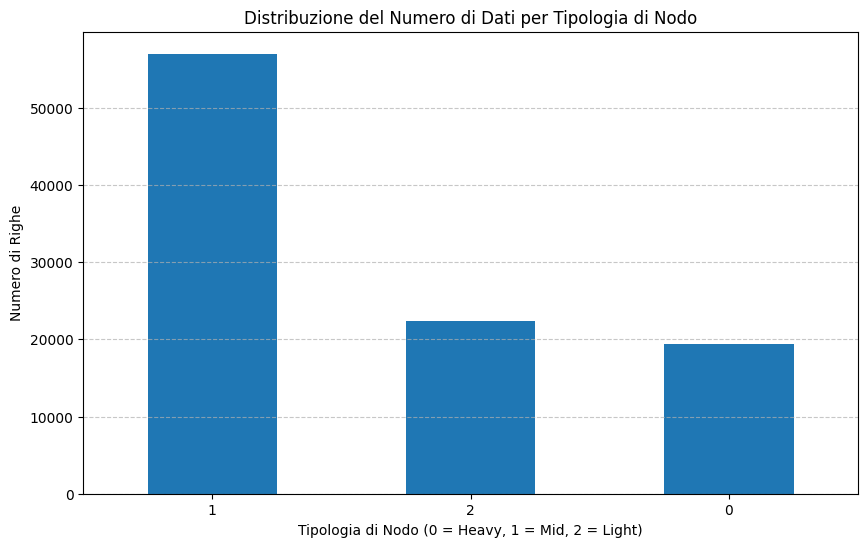

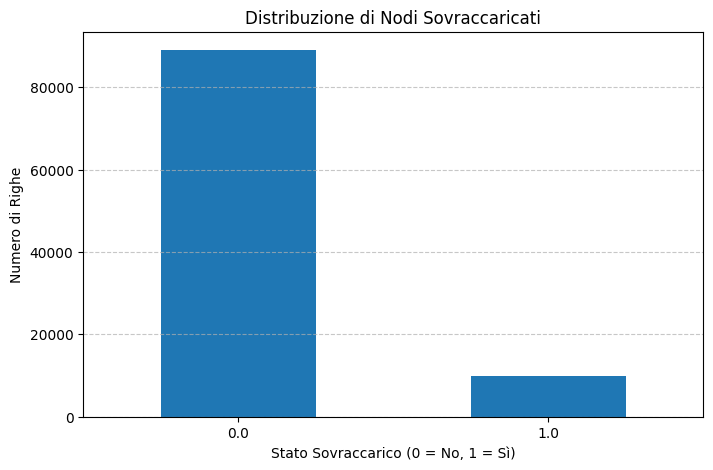

In [133]:
# Plot node type distribution
plot_node_type_distribution(df)
# Plot overloaded node distribution
plot_overloaded_node_distribution(df)

#### Removing outliers

In [134]:
# Iterate over each target column and handle outliers
functions_column = [col for col in df if col.startswith('rate')]
targets = [col for col in df if (col.startswith('power_usage_') or col.startswith('cpu_usage_') or col.startswith('ram_usage_') or col.startswith('overloaded_node') or col.startswith('medium_latency')) and 'idle' not in col]
grouped = df.groupby(functions_column + ['node_type'])
threshold = 1
for target in targets:
    print(target)
    if target != 'overloaded_node':
        mean = grouped[target].transform('mean')
        std = grouped[target].transform('std')
        outliers = (df[target] > mean + threshold * std) | (df[target] < mean - threshold * std)
        print(outliers.sum())
        df[target] = df[target].where(~outliers, mean)
    else:
        new_overloaded = grouped[target].transform('all')
        df['overloaded_node'] = new_overloaded.astype(int)
        print(df["overloaded_node"].value_counts())
df_only_useful = df[functions_column + targets + ["node_type"]]

cpu_usage_function_shasum
23887
ram_usage_function_shasum
23430
power_usage_function_shasum
23895
medium_latency_function_shasum
23610
cpu_usage_function_curl
14017
ram_usage_function_curl
13650
power_usage_function_curl
13997
medium_latency_function_curl
13920
cpu_usage_function_eat-memory
4571
ram_usage_function_eat-memory
4501
power_usage_function_eat-memory
4595
medium_latency_function_eat-memory
4564
cpu_usage_node
32752
ram_usage_node
32400
ram_usage_node_percentage
32140
power_usage_node
32498
overloaded_node
overloaded_node
0    90739
1     8045
Name: count, dtype: int64
cpu_usage_function_nmap
7319
ram_usage_function_nmap
7245
power_usage_function_nmap
7318
medium_latency_function_nmap
7301
cpu_usage_function_env
19397
ram_usage_function_env
18812
power_usage_function_env
19415
medium_latency_function_env
19202
cpu_usage_function_figlet
19900
ram_usage_function_figlet
19762
power_usage_function_figlet
19876
medium_latency_function_figlet
19790


#### Create dataset of groups

In [135]:
# Get the groups definition from the group_list.json 
with open(GROUP_FILE_PATH, 'r') as json_file:
    groups_number = json.load(json_file)

# Map groups number with the correspondent name
groups = {}
for key, value in groups_number.items():
    if "figlet" in value:
        groups["LOW_USAGE"] = value
    elif "nmap" in value:
        groups["HIGH_USAGE"] = value
    else:
        groups["MEDIUM_USAGE"] = value
groups

{'LOW_USAGE': ['curl', 'env', 'figlet', 'shasum'],
 'HIGH_USAGE': ['eat-memory', 'nmap']}

In [162]:
# Build dataframe
df_groups = pd.DataFrame()
df_groups_pred = pd.DataFrame()
group_names_pred = set()
for key, group in groups.items():
    for metric in FUNCTION_COLUMNS:
        temp_columns = []
        temp_columns_pred = []
        for fun in group:
            if fun not in PREDICT_ONLY_FUNCTIONS:
                temp_columns.append(metric + fun)
            else:
                temp_columns_pred.append(metric + fun)
                group_names_pred.add(key)

        # Rename the column name
        col_name = metric.replace('function_', '')
        if col_name == 'rate_':
            col_name = 'rate_group_'

        # Create a dataset where the 0 values in the selected columns are replaced with NaN
        df_groups = create_df_no_zeros(df, temp_columns, metric, df_groups, col_name, key)
        df_groups_pred = create_df_no_zeros(df, temp_columns_pred, metric, df_groups_pred, col_name, key)

df_groups = fill_NaN(df_groups)
df_groups_pred = fill_NaN(df_groups_pred)

# Gets all the node columns names present in df
node_metrics = [col for col in df if col.endswith('node') or 'node_type' in col] 

# Copy all the node columns in df_groups 
for metric in node_metrics:
    df_groups[metric] = df[metric]

# Copy the node type in df_groups_pred
df_groups_pred['node_type'] = df['node_type']

df_groups

rate_group_LOW_USAGE  success_rate_LOW_USAGE  cpu_usage_LOW_USAGE  \
0                      60.0                     1.0            28.338500   
1                      60.0                     1.0            28.120000   
2                      60.0                     1.0            28.826000   
3                      60.0                     1.0            21.107000   
4                      60.0                     1.0            20.506000   
...                     ...                     ...                  ...   
98779                  90.0                     1.0            12.220333   
98780                  90.0                     1.0            12.023000   
98781                 100.0                     1.0            12.879500   
98782                 100.0                     1.0            12.441000   
98783                 100.0                     1.0            12.657000   

       ram_usage_LOW_USAGE  power_usage_LOW_USAGE  replica_LOW_USAGE  \
0             1.003324e+08           15353.293000                2.0   
1             1.003324e+08           16787.090500                1.0   
2             1.003324e+08           17573.238000                2.0   
3             2.114856e+06           19581.845000                3.0   
4             1.466204e+06           20123.008000                2.0   
...                    ...                    ...                ...   
98779         7.224434e+06           35806.323000                2.0   
98780         3.266219e+06           35885.043000                2.0   
98781         8.771019e+06           41522.641167                2.0   
98782         8.978208e+06           41659.913000                2.0   
98783         8.818009e+06           41284.251000                2.0   

       overloaded_LOW_USAGE  medium_latency_LOW_USAGE  rate_group_HIGH_USAGE  \
0                         0              9.586719e+08                    0.0   
1                         0              6.293711e+08                    0.0   
2                         0              1.048772e+09                    0.0   
3                         0              1.016027e+10                   10.0   
4                         0              1.099271e+10                   10.0   
...                     ...                       ...                    ...   
98779                     0              1.445012e+07                   70.0   
98780                     0              1.402006e+07                   70.0   
98781                     0              1.483691e+07                   70.0   
98782                     0              1.903735e+07                   70.0   
98783                     0              1.763610e+07                   70.0   

       success_rate_HIGH_USAGE  ...  overloaded_HIGH_USAGE  \
0                       1.0000  ...                      0   
1                       1.0000  ...                      0   
2                       1.0000  ...                      0   
3                       0.5385  ...                      1   
4                       0.5365  ...                      1   
...                        ...  ...                    ...   
98779                   1.0000  ...                      0   
98780                   0.9880  ...                      0   
98781                   0.9810  ...                      0   
98782                   0.9840  ...                      0   
98783                   0.9755  ...                      0   

       medium_latency_HIGH_USAGE  cpu_usage_idle_node  cpu_usage_node  \
0                   0.000000e+00               59.000      124.895875   
1                   0.000000e+00               64.933      127.617000   
2                   0.000000e+00               61.667      121.317000   
3                   1.436266e+10               72.133      145.871333   
4                   1.472931e+10               62.067      142.147000   
...                          ...                  ...             ...   
98779       

In [143]:
df_groups.columns

Index(['rate_group_LOW_USAGE', 'success_rate_LOW_USAGE', 'cpu_usage_LOW_USAGE',
       'ram_usage_LOW_USAGE', 'power_usage_LOW_USAGE', 'replica_LOW_USAGE',
       'overloaded_LOW_USAGE', 'medium_latency_LOW_USAGE',
       'rate_group_HIGH_USAGE', 'success_rate_HIGH_USAGE',
       'cpu_usage_HIGH_USAGE', 'ram_usage_HIGH_USAGE',
       'power_usage_HIGH_USAGE', 'replica_HIGH_USAGE', 'overloaded_HIGH_USAGE',
       'medium_latency_HIGH_USAGE', 'cpu_usage_idle_node', 'cpu_usage_node',
       'ram_usage_idle_node', 'ram_usage_node', 'power_usage_idle_node',
       'power_usage_node', 'overloaded_node', 'node_type'],
      dtype='object')

In [144]:
df_groups.to_csv(os.path.join(PATH_TO_CVS, "grouped_results_no_outliers.csv"), index = False)

#### Partitioning into features and targets and oversampling

In [163]:
# Dataframe division by features and output
targets = [col for col in df_groups if (col.startswith('power_usage_') or col.startswith('cpu_usage_') or col.startswith('ram_usage_') or col.startswith('overloaded_node') or col.startswith('medium_latency')) and 'idle' not in col]# or col.startswith('replica')
params = [col for col in df_groups if col.startswith('rate_') or 'node_type' in col]

# Initialize a dictionary to store target datasets
target_datasets = {}
features_datasets = {}
features_datasets['original'] = df_groups[params]
for target_name in targets:
    X = df_groups[params]
    y = df_groups[[target_name]]
    node_type_index = X.columns.get_loc("node_type")

    if "overloaded" in target_name:
        print("Status of target: " + target_name)
        print(y.value_counts())
        # Oversampling
        sm = SMOTENC(random_state=42, categorical_features=[node_type_index])
        try:
            X_res, y_res = sm.fit_resample(X, y)
            result_df = pd.concat([X_res, y_res], axis=1)
            print("Status after SMOTE:")
            print(y_res.value_counts())
            print(X_res["node_type"].value_counts())
            features_datasets[target_name] = X_res
            y = y_res
        except:
            print("It was not possible to perform SMOTE for target " + target_name)

    target_datasets[target_name] = y

# Predict-only
targets_pred = [
    col for col in df_groups_pred if (
        col.startswith('power_usage_') or col.startswith('cpu_usage_') or col.startswith('ram_usage_') or col.startswith('medium_latency')
    ) and (
        'idle' not in col and 'node' not in col
    ) and (
        any(col.endswith(g) for g in group_names_pred)
    )
]
features_datasets_pred = {'original': df_groups_pred[params]}
target_datasets_pred = {}
for target_name in targets_pred:
    y = df_groups_pred[[target_name]]
    target_datasets_pred[target_name] = y

Status of target: overloaded_node
overloaded_node
0                  90739
1                   8045
Name: count, dtype: int64
Status after SMOTE:
overloaded_node
0                  90739
1                  90739
Name: count, dtype: int64
node_type
1    84261
2    65801
0    31416
Name: count, dtype: int64


#### Preprocessing

In [165]:
# Initialize dictionaries to store scaled data and train-test splits
x_train_dict = {}
x_test_dict = {}
y_train_dict = {}
y_test_dict = {}
y_scalers = {}
scaler_exist = False

for target_name in targets:
    # Get the target dataset for the current iteration
    target_dataset = target_datasets[target_name]

    # Apply scaling for x (features)
    if "overloaded" in target_name:
        X = features_datasets[target_name]
    else:
        X = features_datasets['original']
    scaler_x = MinMaxScaler()
    scaler_x.fit(X)
    X_scaled = scaler_x.transform(X)

    # Apply scaling for y (target)
    scaler_y = MinMaxScaler()
    scaler_y.fit(target_dataset)
    y_scalers[target_name] = scaler_y
    if target_name.startswith('overloaded') or target_name.startswith('replica'):
        y_scaled = target_dataset
    else:
        y_scaled = scaler_y.transform(target_dataset)

    # Save the scaler for x
    scaler_x_path = './scalers/groups/scaler_x/' 
    if not os.path.exists(scaler_x_path):
        os.makedirs(scaler_x_path)
    if target_name.startswith('overloaded'):
        joblib.dump(scaler_x, scaler_x_path + "/" + target_name + ".joblib")
    elif not scaler_exist:
        scaler_exist = True
        joblib.dump(scaler_x, scaler_x_path + "/features.joblib")

    # Save the scaler for y
    scaler_y_path = './scalers/groups/scaler_y/'
    if not os.path.exists(scaler_y_path):
        os.makedirs(scaler_y_path)
    if not target_name.startswith("overloaded"):
        joblib.dump(scaler_y, scaler_y_path + "/" + target_name + ".joblib")

    # Split the dataset into training and testing
    x_train, x_test, y_train, y_test = train_test_split(X_scaled, y_scaled)
    x_train_dict[target_name] = x_train
    x_test_dict[target_name] = x_test
    y_train_dict[target_name] = y_train
    y_test_dict[target_name] = y_test

# Predict-only
x_test_dict_pred = {}
y_test_dict_pred = {}
for target_name in targets_pred:
    # Get the target dataset for the current iteration
    target_dataset = target_datasets_pred[target_name]
    
    # Apply scaling for x
    X = features_datasets_pred['original']
    scaler_x = joblib.load('./scalers/groups/scaler_x/features.joblib')
    X_scaled = scaler_x.transform(X)

    # Apply scaling for y (target)
    scaler_y = y_scalers[target_name]
    y_scaled = scaler_y.transform(target_dataset)

    x_test_dict_pred[target_name] = X_scaled
    y_test_dict_pred[target_name] = y_scaled

#### Train models

In [147]:
#One Model for each target variable
#Initialize a dictionary to store models
trained_models = {}
for target_name in targets:
    #Get the corresponding x_train for the current target
    x_train = x_train_dict[target_name]

    # Get the corresponding y_train for the current target
    y_train = y_train_dict[target_name]

    #Trains the specific model for the current target
    model = train_model(target_name, x_train, y_train, 0)  # Use the specific target's y_train
    trained_models[target_name] = model
    if not(target_name.startswith('overloaded') or target_name.startswith('replica')):
        for quantile in QUANTILES:
            model = train_model(target_name, x_train, y_train, quantile)
            trained_models[target_name + " " + str(quantile)] = model

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 54
[LightGBM] [Info] Number of data points in the train set: 74088, number of used features: 3
[LightGBM] [Info] Start training from score 0.214558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 54
[LightGBM] [Info] Number of data points in the train set: 74088, number of used features: 3
[LightGBM] [Info] Start training from score 0.022445
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

#### Predict

In [150]:
# Initialize dictionary to store predictions
all_predictions = {}
for target_name in targets:

    # Get the test dataset for the current iteration
    x_test = x_test_dict[target_name]
    y_test = y_test_dict[target_name]
    test_data = pd.DataFrame(np.column_stack((x_test, y_test)), columns=[*params, target_name])

    # Load trained model and predict
    model = trained_models[target_name]
    y_pred = model.predict(test_data.drop(columns=[target_name]))
    all_predictions[target_name] = y_pred
    if not(target_name.startswith('overloaded') or target_name.startswith('replica')):
        y_pred_quantiles = {}
        for quantile in QUANTILES:
            model = trained_models[target_name + " " + str(quantile)]
            y_pred_quantiles[str(quantile)] = model.predict(test_data.drop(columns=[target_name]))
        all_predictions[target_name + " quantiles"] = y_pred_quantiles

In [166]:
# Compute predictions for the predictions-only test set
pred_only_predictions = {}
if len(PREDICT_ONLY_FUNCTIONS) > 0:
    for target_name in targets_pred:

        # Get the test dataset for the current iteration
        x_test = x_test_dict_pred[target_name]
        y_test = y_test_dict_pred[target_name]
        test_data = pd.DataFrame(np.column_stack((x_test, y_test)), columns=[*params, target_name])

        # Load trained model and predict
        model = trained_models[target_name]
        y_pred = model.predict(test_data.drop(columns=[target_name]))
        pred_only_predictions[target_name] = y_pred
        if not(target_name.startswith('overloaded') or target_name.startswith('replica')):
            y_pred_quantiles = {}
            for quantile in QUANTILES:
                model = trained_models[target_name + " " + str(quantile)]
                y_pred_quantiles[str(quantile)] = model.predict(test_data.drop(columns=[target_name]))
            pred_only_predictions[target_name + " quantiles"] = y_pred_quantiles

#### Plot results

Target: cpu_usage_LOW_USAGE
mape: 74828245375.61226
mse: 0.014839294115647637
rmse: 0.12181664137402425
R-squared score: 0.4318577074997789
Standard deviation: 0.1069118244764163


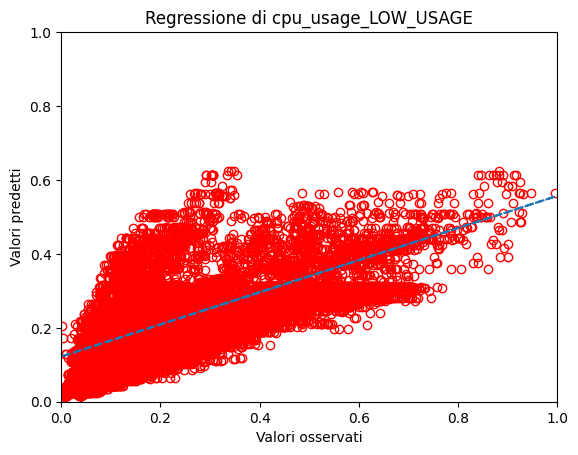

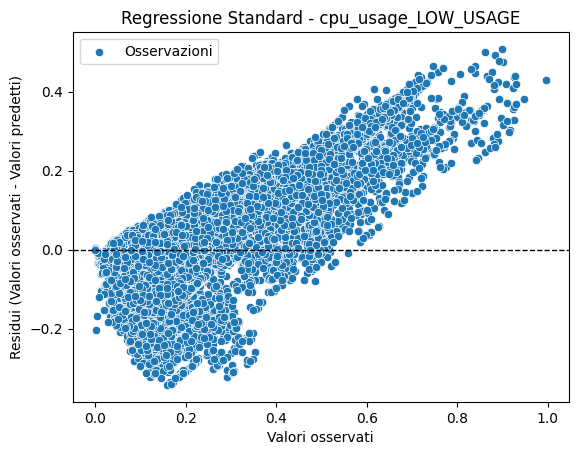

mape: 10648433458096.637
mse: 300.5062866295513
rmse: 17.335117150730518
R-squared score: 0.43185770749977914
Standard deviation: 15.21408718211642
Quantile loss with library:  6.613916415855837
------------------------------
Target: cpu_usage_LOW_USAGE quantiles
Prediction for alpha 0.05 are greater than true values in 6.928247489471979 % of cases and less or equal in 93.07175251052801 % of cases.
mape: 53706371.53838657
mse: 0.03049317292317239
rmse: 0.17462294500772912
R-squared score: -0.16747205326354786
Standard deviation: 0.06994647248565979
Quantile loss with library:  0.005662498067324479
Prediction for alpha 0.95 are greater than true values in 94.91415613864594 % of cases and less or equal in 5.085843861354065 % of cases.
mape: 3421986704974.196
mse: 0.05870406436438075
rmse: 0.24228921636007814
R-squared score: -1.2475638967146523
Standard deviation: 0.19133435010922664
Quantile loss with library:  0.010619588991299623


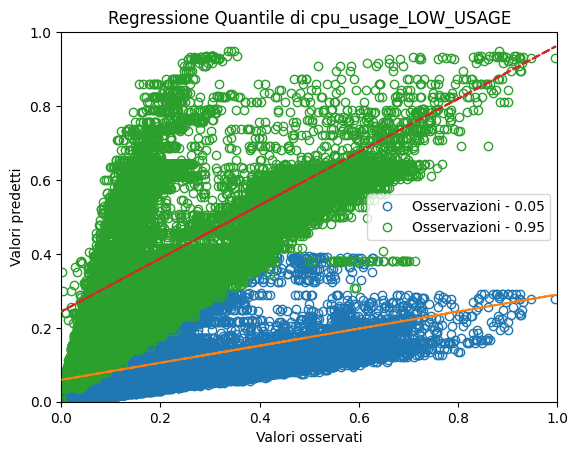

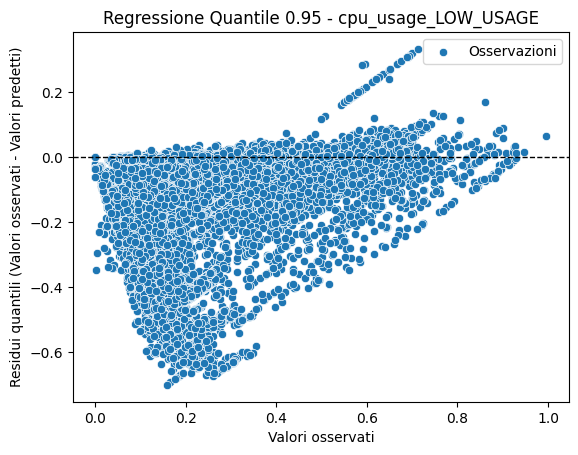

mape: 486965818051139.0
mse: 1188.7991608442035
rmse: 34.47896693412092
R-squared score: -1.2475638967146523
Standard deviation: 27.227834692293495
Quantile loss with library:  1.5112206114068931
------------------------------
Target: ram_usage_LOW_USAGE
mape: 144706400288.35962
mse: 0.03553860418202117
rmse: 0.18851685384076716
R-squared score: 0.20174155444309483
Standard deviation: 0.09560637237280145


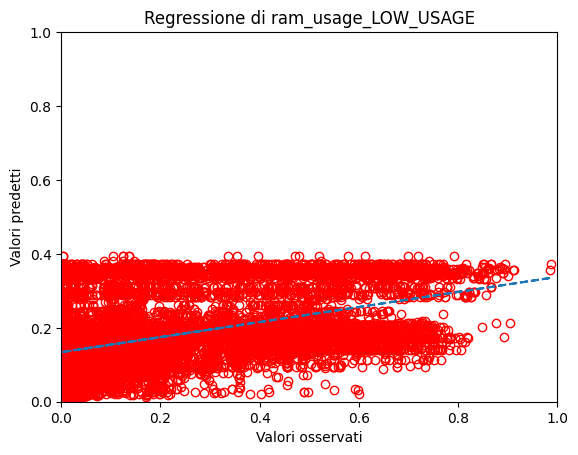

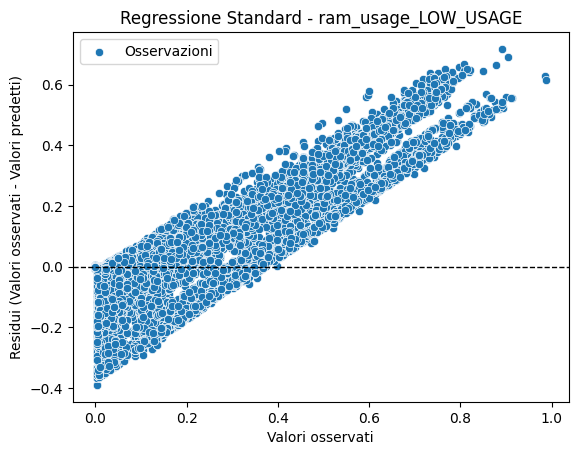

mape: 4.902870969826531e+19
mse: 4079677318813815.5
rmse: 63872351.75577783
R-squared score: 0.20174155444309472
Standard deviation: 32392880.115893845
Quantile loss with library:  24129686.427876513
------------------------------
Target: ram_usage_LOW_USAGE quantiles
Prediction for alpha 0.05 are greater than true values in 7.288629737609329 % of cases and less or equal in 92.71137026239067 % of cases.
mape: 10356265.814818537
mse: 0.07020439339808977
rmse: 0.26496111676638473
R-squared score: -0.576911959124597
Standard deviation: 0.008935556420185961
Quantile loss with library:  0.008106506021663915
Prediction for alpha 0.95 are greater than true values in 94.97084548104957 % of cases and less or equal in 5.029154518950437 % of cases.
mape: 7011775170637.02
mse: 0.16365686242053964
rmse: 0.40454525385986134
R-squared score: -2.6760158595826544
Standard deviation: 0.21678210782765198
Quantile loss with library:  0.019672327687081374


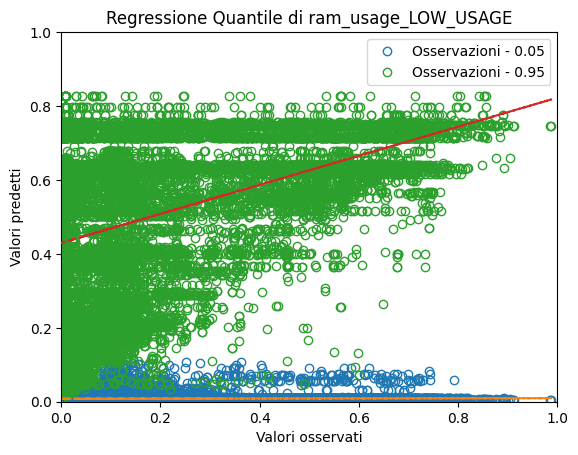

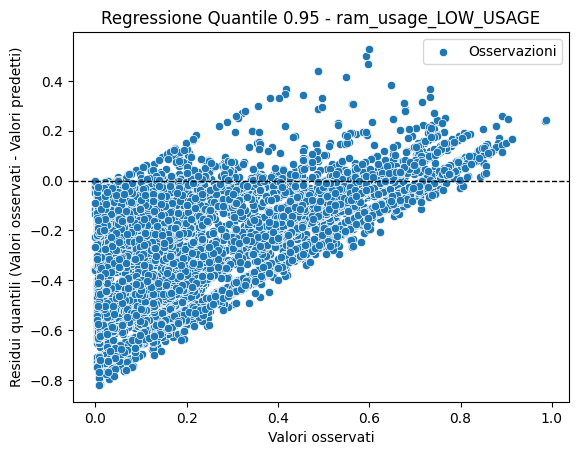

mape: 2.3756951222438367e+21
mse: 1.878709659686293e+16
rmse: 137066030.0616565
R-squared score: -2.676015859582654
Standard deviation: 73449045.87269552
Quantile loss with library:  6665281.158073647
------------------------------
Target: power_usage_LOW_USAGE
mape: 52645248431.73849
mse: 0.004477554062430047
rmse: 0.06691452803711648
R-squared score: 0.7838300700993355
Standard deviation: 0.12736366306952243


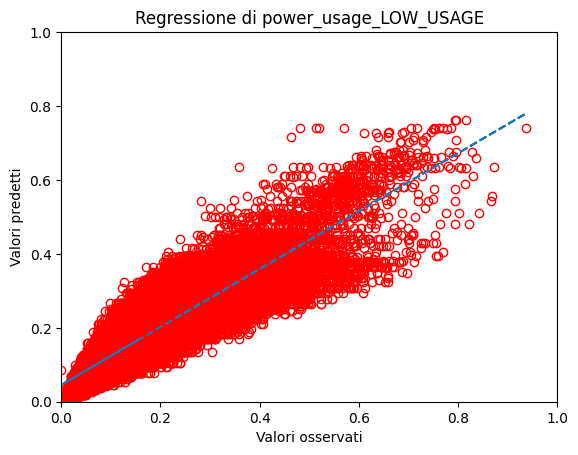

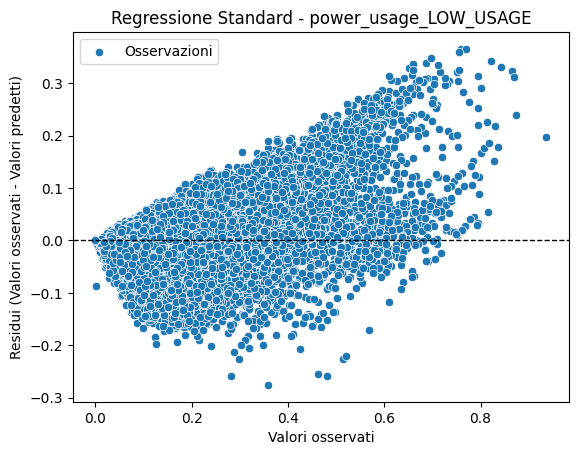

mape: 8987594232597595.0
mse: 130499663.89076106
rmse: 11423.644947684652
R-squared score: 0.7838300700993355
Standard deviation: 21743.518318409384
Quantile loss with library:  4174.139604301878
------------------------------
Target: power_usage_LOW_USAGE quantiles
Prediction for alpha 0.05 are greater than true values in 7.3615160349854225 % of cases and less or equal in 92.63848396501457 % of cases.
mape: 56779020.58777195
mse: 0.012004230521637302
rmse: 0.1095638194005544
R-squared score: 0.42045285569027235
Standard deviation: 0.09891185447397055
Quantile loss with library:  0.004373879112945771
Prediction for alpha 0.95 are greater than true values in 94.95464852607711 % of cases and less or equal in 5.045351473922902 % of cases.
mape: 532402272101.1506
mse: 0.01897496626567431
rmse: 0.13774965069165987
R-squared score: 0.08391566682900942
Standard deviation: 0.17410968239471736
Quantile loss with library:  0.0063749697256984


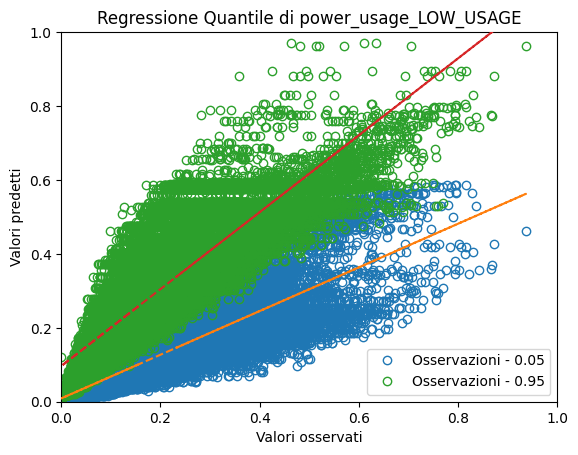

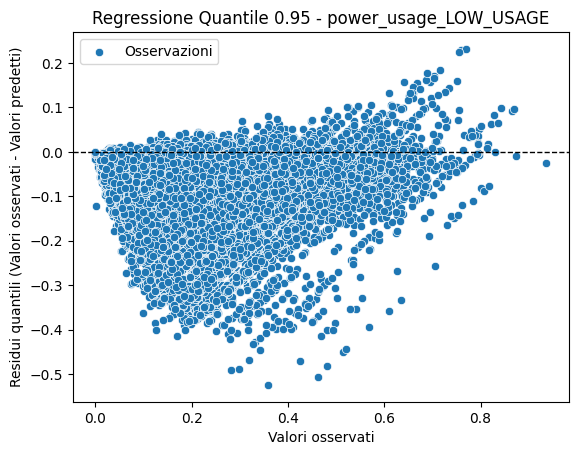

mape: 9.089168980526707e+16
mse: 553031115.9805706
rmse: 23516.613616347284
R-squared score: 0.08391566682900942
Standard deviation: 29723.99644705171
Quantile loss with library:  1088.3345191977146
------------------------------
Target: medium_latency_LOW_USAGE
mape: 81313717895.91753
mse: 0.009080253839255155
rmse: 0.09529036593095419
R-squared score: 0.34905874542388315
Standard deviation: 0.0702147608769595


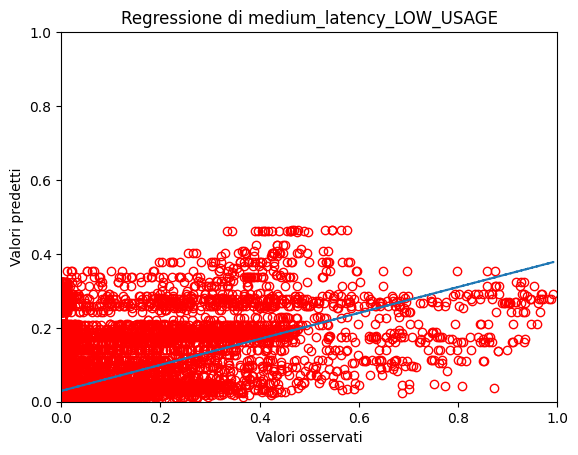

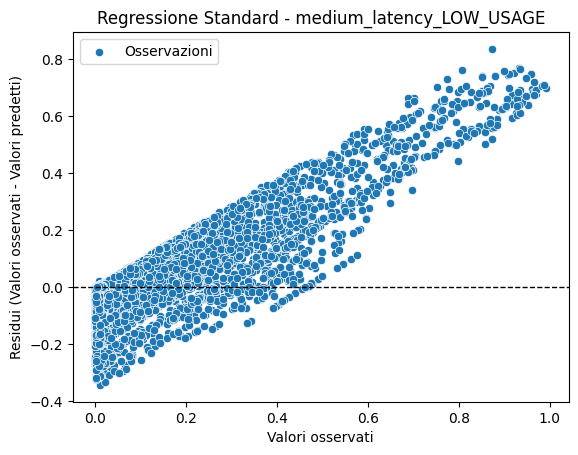

mape: 2.2705522116625398e+21
mse: 7.080001315645594e+18
rmse: 2660827186.354949
R-squared score: 0.34905874542388315
Standard deviation: 1960632040.8109162
Quantile loss with library:  645515689.74903
------------------------------
Target: medium_latency_LOW_USAGE quantiles
Prediction for alpha 0.05 are greater than true values in 7.171201814058957 % of cases and less or equal in 92.82879818594104 % of cases.
mape: 607635.4842988272
mse: 0.014976650671913222
rmse: 0.12237912678195258
R-squared score: -0.07363956452159393
Standard deviation: 0.020545368315826727
Quantile loss with library:  0.0021815707736380927
Prediction for alpha 0.95 are greater than true values in 95.16520894071915 % of cases and less or equal in 4.834791059280855 % of cases.
mape: 655512999541.3591
mse: 0.04478391014231119
rmse: 0.21162209275572147
R-squared score: -2.2104493077972602
Standard deviation: 0.1975556860939379
Quantile loss with library:  0.009174033662952503


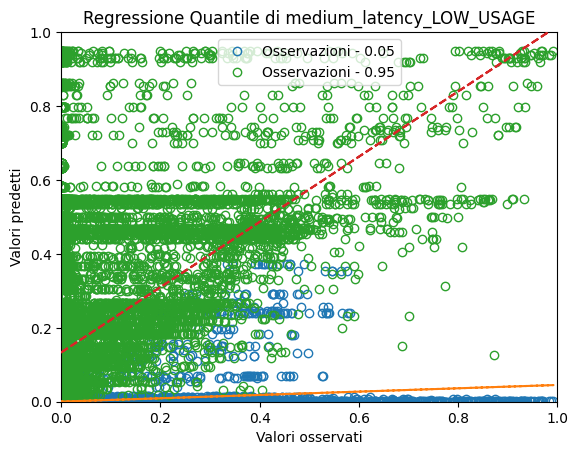

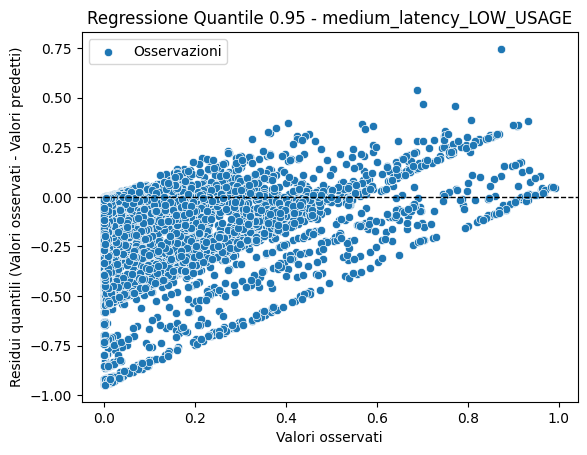

mape: 1.8304125424398424e+22
mse: 3.491864306222151e+19
rmse: 5909199866.498129
R-squared score: -2.2104493077972602
Standard deviation: 5516418530.27031
Quantile loss with library:  256169844.03866124
------------------------------
Target: cpu_usage_HIGH_USAGE
mape: 56416689307.68527
mse: 0.0006882283123142737
rmse: 0.026234105898891878
R-squared score: 0.9802257876766302
Standard deviation: 0.18504943381602637


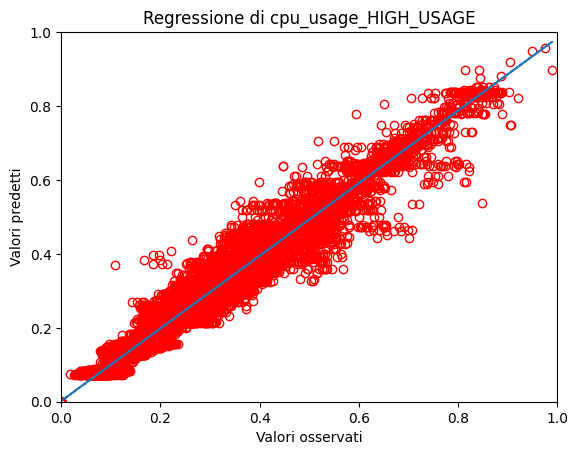

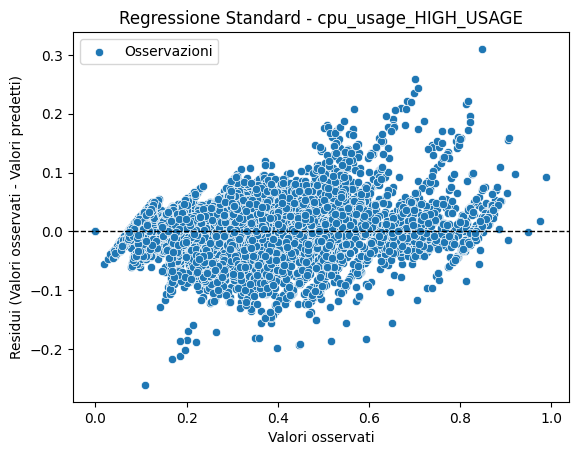

mape: 20809013767675.77
mse: 93.63114533106338
rmse: 9.676318790276774
R-squared score: 0.9802257876766302
Standard deviation: 68.25455841587224
Quantile loss with library:  2.082874624318567
------------------------------
Target: cpu_usage_HIGH_USAGE quantiles
Prediction for alpha 0.05 are greater than true values in 1.8059604794298671 % of cases and less or equal in 98.19403952057013 % of cases.
mape: 0.07655690007401533
mse: 0.002343650685450075
rmse: 0.04841126610046544
R-squared score: 0.9326621043675714
Standard deviation: 0.15541413742858148
Quantile loss with library:  0.0012103230738072259
Prediction for alpha 0.95 are greater than true values in 97.84580498866214 % of cases and less or equal in 2.1541950113378685 % of cases.
mape: 169833447534.23904
mse: 0.0024764792747134497
rmse: 0.04976423690476374
R-squared score: 0.9288456663052147
Standard deviation: 0.21408065574575127
Quantile loss with library:  0.0012373408344055754


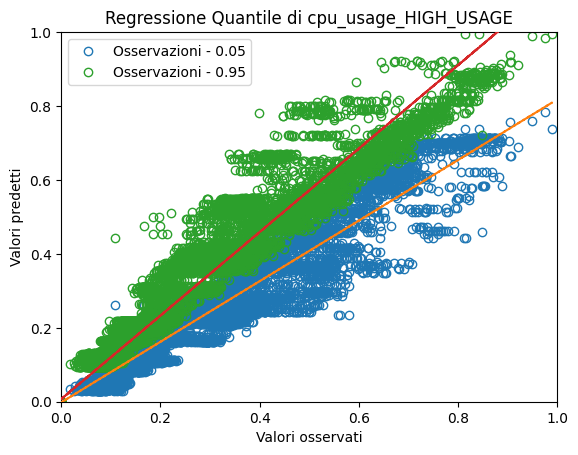

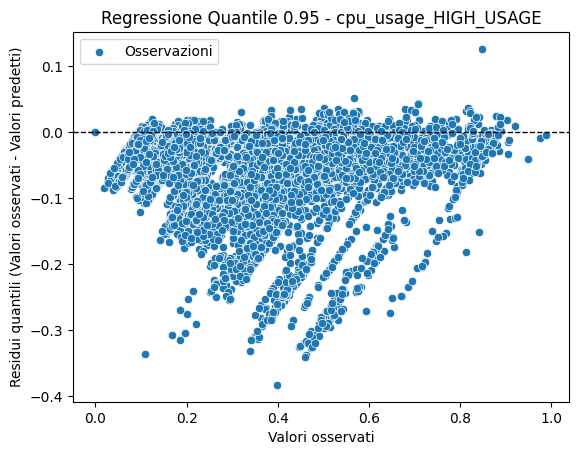

mape: 62642217955729.9
mse: 336.9166695574381
rmse: 18.355289961137583
R-squared score: 0.9288456663052147
Standard deviation: 78.96257946854162
Quantile loss with library:  0.4563869800663246
------------------------------
Target: ram_usage_HIGH_USAGE
mape: 278587557219.2182
mse: 0.008670997911636266
rmse: 0.09311819323653282
R-squared score: 0.5851047432991914
Standard deviation: 0.10734037483391325


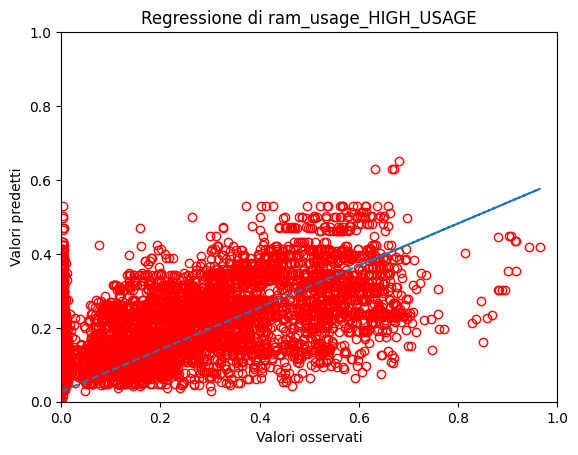

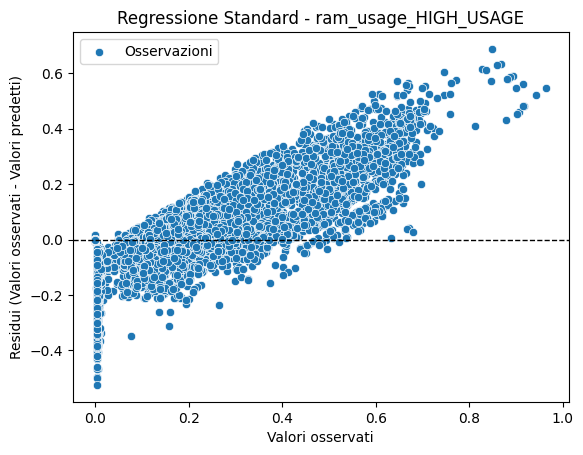

mape: 1.2510489918600631e+20
mse: 1748615346606482.8
rmse: 41816448.27823715
R-squared score: 0.5851047432991914
Standard deviation: 48203182.17523065
Quantile loss with library:  9773860.605861472
------------------------------
Target: ram_usage_HIGH_USAGE quantiles
Prediction for alpha 0.05 are greater than true values in 1.9355361192095886 % of cases and less or equal in 98.06446388079041 % of cases.
mape: 0.2621370843059902
mse: 0.02356963257342991
rmse: 0.15352404558709984
R-squared score: -0.127774318083258
Standard deviation: 0.01941934580786341
Quantile loss with library:  0.003280887050453505
Prediction for alpha 0.95 are greater than true values in 98.01587301587301 % of cases and less or equal in 1.984126984126984 % of cases.
mape: 31668709595.474693
mse: 0.03332108214789462
rmse: 0.18254063149856423
R-squared score: -0.594367692413694
Standard deviation: 0.22608699582282374
Quantile loss with library:  0.004776266227953845


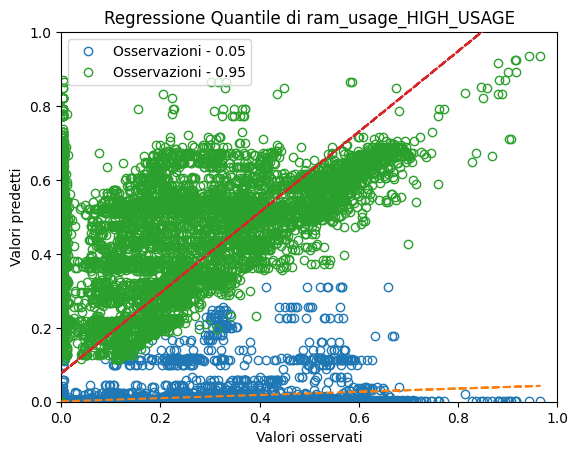

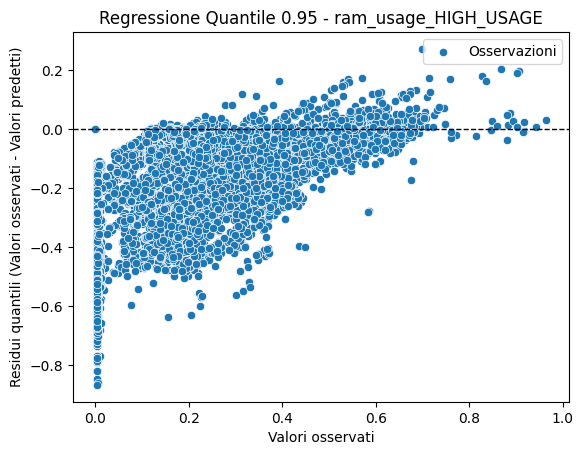

mape: 1.4221420221755648e+19
mse: 6719613613463408.0
rmse: 81973249.3772414
R-squared score: -0.5943676924136936
Standard deviation: 101528550.31446211
Quantile loss with library:  2144870.75771531
------------------------------
Target: power_usage_HIGH_USAGE
mape: 52278829502.884285
mse: 0.0004700863495941165
rmse: 0.021681474802100444
R-squared score: 0.9790288145666978
Standard deviation: 0.1476271164471456


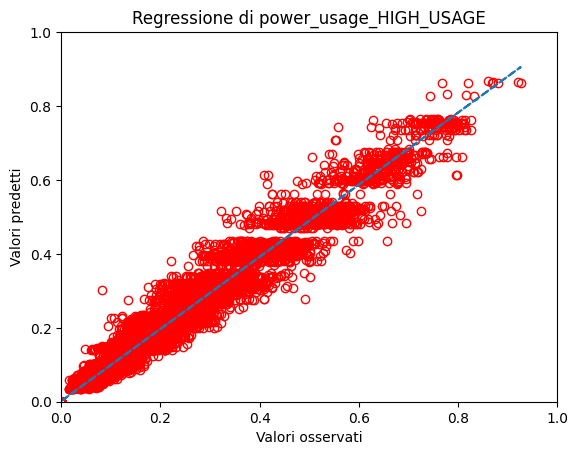

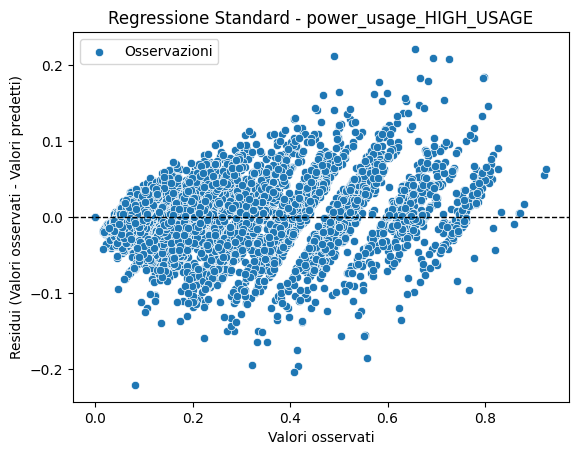

mape: 3075656752804440.5
mse: 1627052.8561259005
rmse: 1275.5598206771413
R-squared score: 0.9790288145666978
Standard deviation: 8685.166479734202
Quantile loss with library:  272.9912644085796
------------------------------
Target: power_usage_HIGH_USAGE quantiles
Prediction for alpha 0.05 are greater than true values in 1.7938127632005183 % of cases and less or equal in 98.20618723679948 % of cases.
mape: 0.09334456348576722
mse: 0.0018679581519627805
rmse: 0.04321988144318284
R-squared score: 0.9166678700194483
Standard deviation: 0.11934136760624584
Quantile loss with library:  0.0011274905719193579
Prediction for alpha 0.95 are greater than true values in 97.8862973760933 % of cases and less or equal in 2.1137026239067054 % of cases.
mape: 3420314910485.1616
mse: 0.001695645179012087
rmse: 0.04117821243099422
R-squared score: 0.9243549839112527
Standard deviation: 0.17389274186125478
Quantile loss with library:  0.0011826989021288439


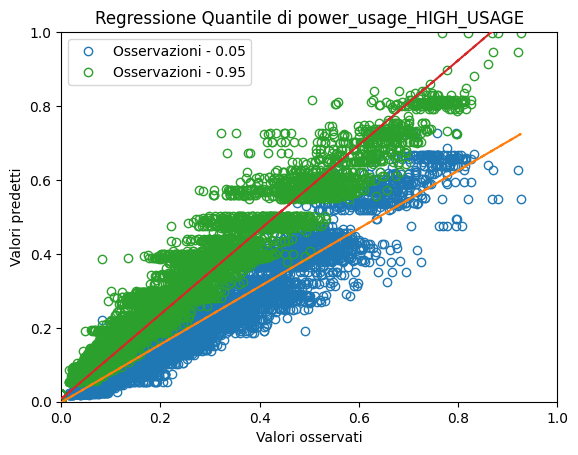

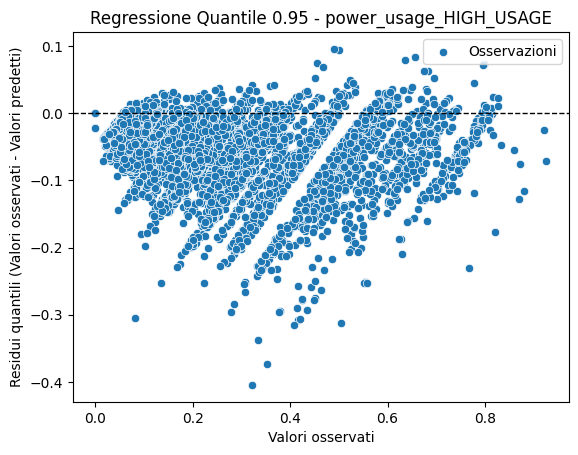

mape: 2.0122322460532006e+17
mse: 5868930.961024146
rmse: 2422.5876580681547
R-squared score: 0.9243549839112527
Standard deviation: 10230.42005445636
Quantile loss with library:  69.58028516438237
------------------------------
Target: medium_latency_HIGH_USAGE
mape: 69374786439.34644
mse: 0.006784455594794433
rmse: 0.08236780678635576
R-squared score: 0.828946998836076
Standard deviation: 0.18092644835332233


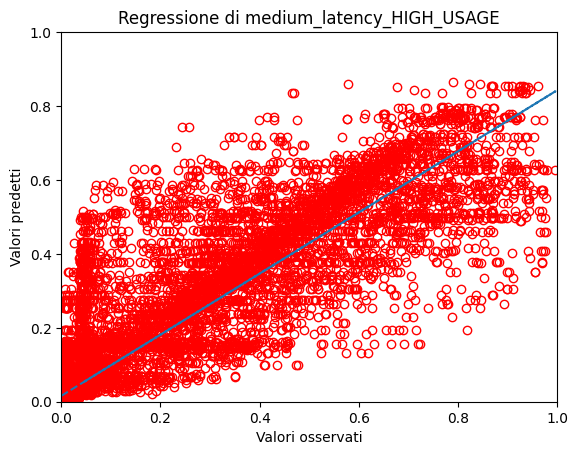

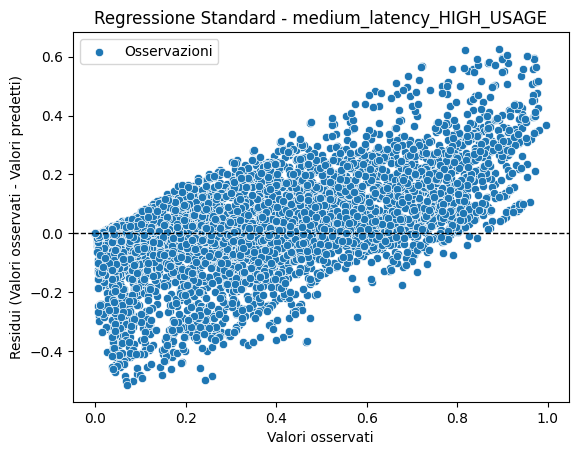

mape: 2.0510546750511715e+21
mse: 5.930156583882767e+18
rmse: 2435191282.8118386
R-squared score: 0.828946998836076
Standard deviation: 5349062055.311405
Quantile loss with library:  461509037.05717105
------------------------------
Target: medium_latency_HIGH_USAGE quantiles
Prediction for alpha 0.05 are greater than true values in 1.7735665694849367 % of cases and less or equal in 98.22643343051506 % of cases.
mape: 0.19621129478451824
mse: 0.023105710077931163
rmse: 0.15200562515226587
R-squared score: 0.4174475759136572
Standard deviation: 0.1020775029489954
Quantile loss with library:  0.002893035172078158
Prediction for alpha 0.95 are greater than true values in 98.12115322319403 % of cases and less or equal in 1.8788467768059605 % of cases.
mape: 46299621344.25257
mse: 0.025532549145356204
rmse: 0.15978907705270784
R-squared score: 0.35626092651714225
Standard deviation: 0.278087636633837
Quantile loss with library:  0.0037323435606496703


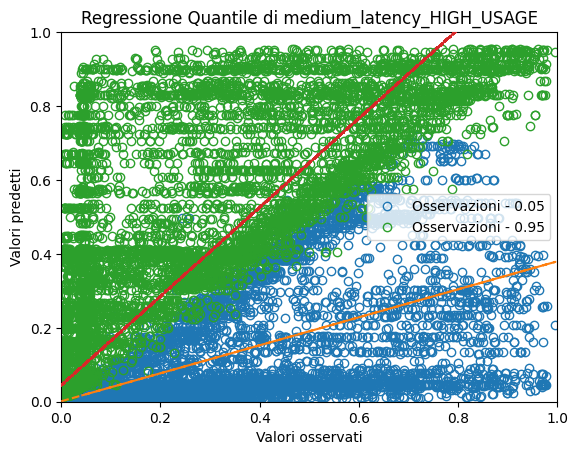

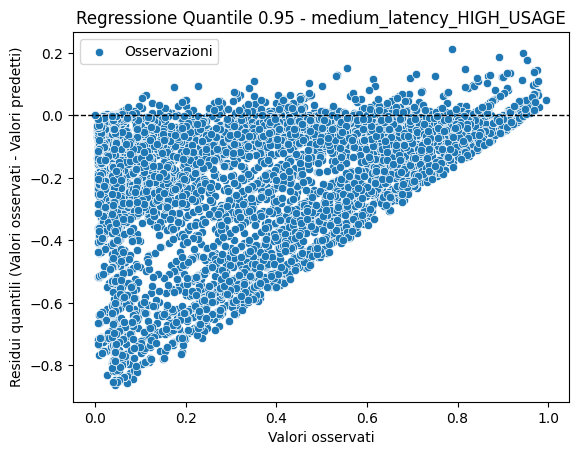

mape: 1.368841039849425e+21
mse: 2.231748919306357e+19
rmse: 4724138989.600493
R-squared score: 0.35626092651714214
Standard deviation: 8221617340.679802
Quantile loss with library:  110346151.70618534
------------------------------
Target: cpu_usage_node
mape: 0.20324092701743288
mse: 0.004754218470853315
rmse: 0.06895084097277795
R-squared score: 0.8588864629277582
Standard deviation: 0.17022170568920147


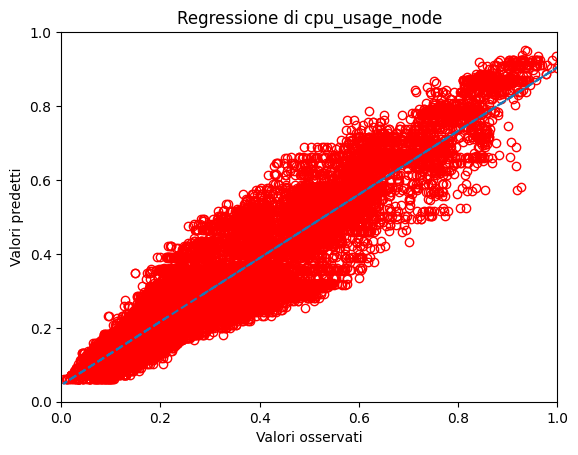

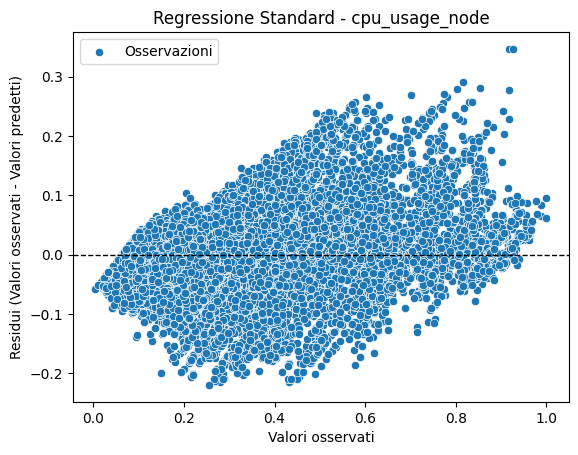

mape: 0.12241569588760616
mse: 831.1332015397015
rmse: 28.82938087333305
R-squared score: 0.8588864629277582
Standard deviation: 71.17224847424046
Quantile loss with library:  11.09357308779409
------------------------------
Target: cpu_usage_node quantiles
Prediction for alpha 0.05 are greater than true values in 5.081794622610949 % of cases and less or equal in 94.91820537738906 % of cases.
mape: 0.2907247654383184
mse: 0.013804413340321174
rmse: 0.11749218416695288
R-squared score: 0.5902608166615605
Standard deviation: 0.1590176853647444
Quantile loss with library:  0.005041264349021373
Prediction for alpha 0.95 are greater than true values in 94.881762228701 % of cases and less or equal in 5.118237771298996 % of cases.
mape: 0.48246771345965433
mse: 0.019663237744535683
rmse: 0.14022566721016408
R-squared score: 0.41636063941213597
Standard deviation: 0.18759868713599723
Quantile loss with library:  0.006375148976639843


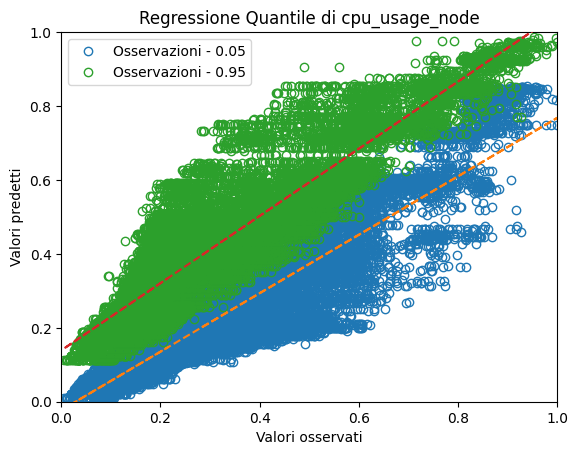

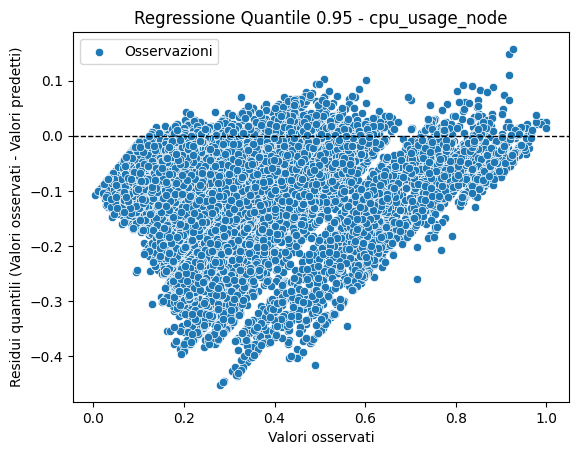

mape: 0.2835214803577587
mse: 3437.5302353993306
rmse: 58.630454845577745
R-squared score: 0.4163606394121362
Standard deviation: 78.43782507186748
Quantile loss with library:  2.665545414367768
------------------------------
Target: ram_usage_node
mape: 0.12436121198932784
mse: 0.005706062663853416
rmse: 0.07553848465420403
R-squared score: 0.6812669273394443
Standard deviation: 0.11108329795575783


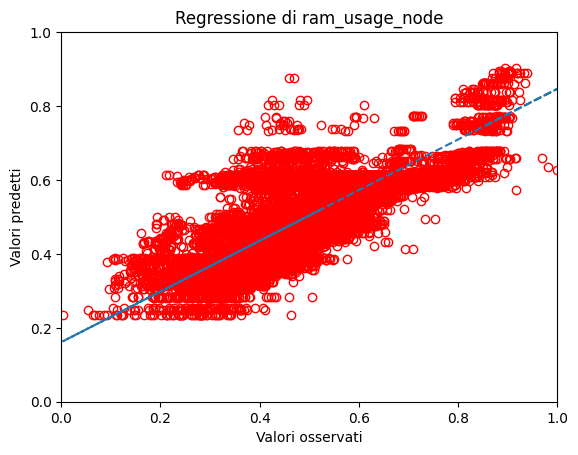

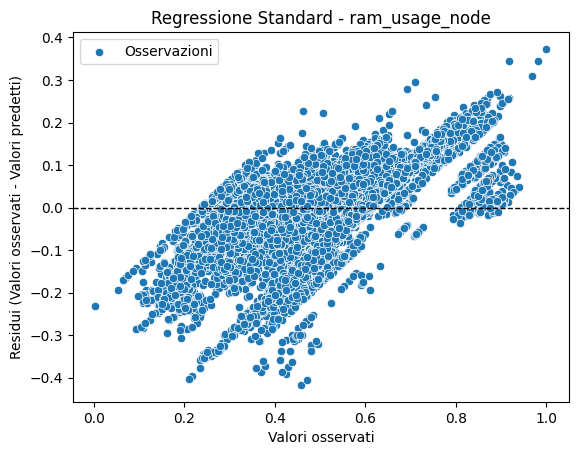

mape: 0.04087958899413958
mse: 6.2488696260113736e+16
rmse: 249977391.49793875
R-squared score: 0.6812669273394443
Standard deviation: 367604846.5770121
Quantile loss with library:  86141939.49311224
------------------------------
Target: ram_usage_node quantiles
Prediction for alpha 0.05 are greater than true values in 5.247813411078718 % of cases and less or equal in 94.75218658892129 % of cases.
mape: 0.2663434947227932
mse: 0.025179540328164593
rmse: 0.1586806236695728
R-squared score: -0.4064956397721131
Standard deviation: 0.10319951050495639
Quantile loss with library:  0.009460198254109988
Prediction for alpha 0.95 are greater than true values in 94.9060576611597 % of cases and less or equal in 5.093942338840298 % of cases.
mape: 0.22191923157820428
mse: 0.014591640020746064
rmse: 0.12079586094211202
R-squared score: 0.18493039194414918
Standard deviation: 0.12216174211332581
Quantile loss with library:  0.00547476788440969


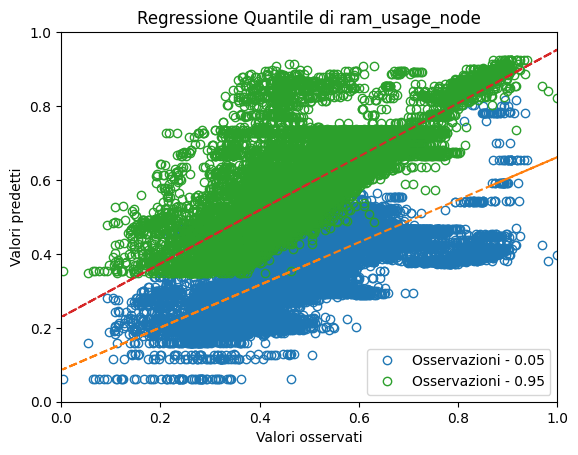

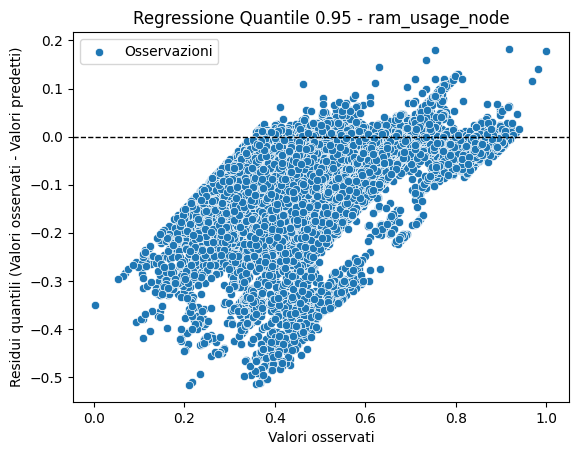

mape: 0.07184932483495407
mse: 1.5979715171539235e+17
rmse: 399746359.2271884
R-squared score: 0.1849303919441495
Standard deviation: 404266431.5299251
Quantile loss with library:  18117496.016320422
------------------------------
Target: power_usage_node
mape: 0.22967665528663786
mse: 0.0030507574994883095
rmse: 0.05523366273830036
R-squared score: 0.8581016286801753
Standard deviation: 0.1362051050731508


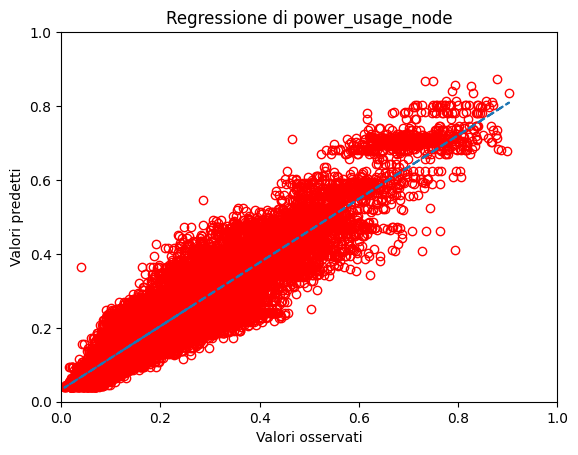

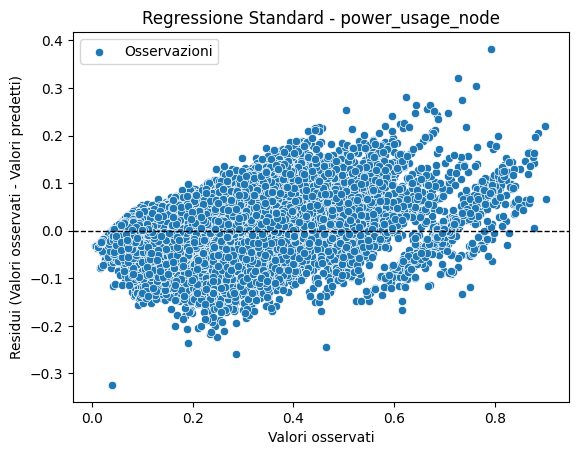

mape: 0.18384909816765233
mse: 48795981940.11624
rmse: 220898.1257053039
R-squared score: 0.8581016286801753
Standard deviation: 544730.3497634898
Quantile loss with library:  84234.1020188929
------------------------------
Target: power_usage_node quantiles
Prediction for alpha 0.05 are greater than true values in 5.142533203757694 % of cases and less or equal in 94.8574667962423 % of cases.
mape: 0.341027305632363
mse: 0.009921059243544837
rmse: 0.09960451417252551
R-squared score: 0.538546689252546
Standard deviation: 0.11638197791758151
Quantile loss with library:  0.004468358055548509
Prediction for alpha 0.95 are greater than true values in 94.74813735017817 % of cases and less or equal in 5.251862649821834 % of cases.
mape: 0.5294736158256269
mse: 0.011514506356599199
rmse: 0.10730566786800778
R-squared score: 0.46443147355132597
Standard deviation: 0.15877555831980605
Quantile loss with library:  0.005305542159964128


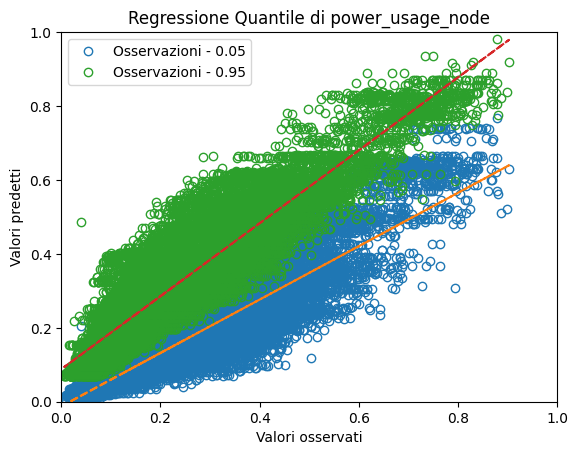

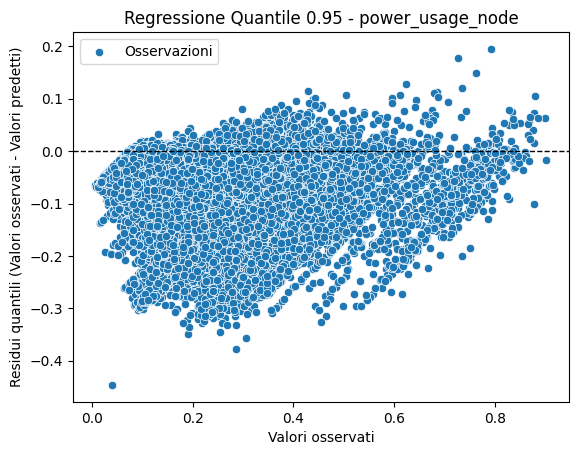

mape: 0.41975779213245756
mse: 184171191686.0671
rmse: 429151.71173614945
R-squared score: 0.46443147355132597
Standard deviation: 634997.2372253651
Quantile loss with library:  21218.660159103718
------------------------------
Target: overloaded_node
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.85      0.90     22645
           1       0.87      0.95      0.91     22725

    accuracy                           0.90     45370
   macro avg       0.91      0.90      0.90     45370
weighted avg       0.91      0.90      0.90     45370

Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.85      0.90     22645
         1.0       0.87      0.95      0.91     22725

    accuracy                           0.90     45370
   macro avg       0.91      0.90      0.90     45370
weighted avg       0.91      0.90      0.90     45370

------------------------------


In [152]:
quantiles_string = [str(q) for q in QUANTILES]
all_metrics = {}
all_metrics_no_scale = {}
for target_name, y_pred in all_predictions.items():
    print(f"Target: {target_name}")

    if target_name.startswith('overloaded'):
        task_type = 'binary classification'
    elif target_name.startswith('replica'):
        task_type = 'classification'
    else:
        task_type = 'regression'

    if target_name.endswith('quantiles'):
        # Get the test dataset for the current iteration
        trunc_target = target_name[0:target_name.index(' ')]
        y_test = y_test_dict[trunc_target]
        y_test_df = pd.DataFrame(y_test, columns=[trunc_target])
        y_pred_df = pd.DataFrame(y_pred, columns=quantiles_string)
        for quantile in QUANTILES:
            statistics = (y_pred_df[str(quantile)] > y_test_df[trunc_target]).value_counts(normalize=True)
            if statistics.size > 1:
                true_percentage, false_percentage = statistics[True], statistics[False]
                print(f"Prediction for alpha {quantile} are greater than true values in {true_percentage * 100} % of cases and less or equal in {false_percentage * 100} % of cases.")
            all_metrics[target_name] = metrics(task_type, y_test_df, y_pred_df[str(quantile)], quantile) 
        plot_quantile_regression(y_test, y_pred_df, trunc_target)            
        # metrics on non-scaled predictions
        y_test_df_not_scaled = pd.DataFrame()
        for col in y_test_df:
            y_test_df_not_scaled[col] = [y[0] for y in y_scalers[trunc_target].inverse_transform(pd.DataFrame(y_test_df[col])).tolist()]
        y_pred_df_not_scaled = pd.DataFrame()
        for col in y_pred_df:
            y_pred_df_not_scaled[col] = [y[0] for y in y_scalers[trunc_target].inverse_transform(pd.DataFrame(y_pred_df[col])).tolist()]
        all_metrics_no_scale[target_name] = metrics(task_type, y_test_df_not_scaled, y_pred_df_not_scaled[str(quantile)], quantile) 
    else:
        y_test = y_test_dict[target_name]
        y_test_df = pd.DataFrame(y_test, columns=[target_name])
        y_pred_df = pd.DataFrame(y_pred, columns=[target_name])
        all_metrics[target_name] = metrics(task_type, y_test_df, y_pred_df, 0)
        if task_type == 'regression':
            plot_regression(y_test, y_pred, target_name)   
        # metrics on non-scaled predictions
        y_test_df_not_scaled = pd.DataFrame()
        for col in y_test_df:
            y_test_df_not_scaled[col] = [y[0] for y in y_scalers[target_name].inverse_transform(pd.DataFrame(y_test_df[col])).tolist()]
        y_pred_df_not_scaled = pd.DataFrame()
        for col in y_pred_df:
            y_pred_df_not_scaled[col] = [y[0] for y in y_scalers[target_name].inverse_transform(pd.DataFrame(y_pred_df[col])).tolist()]
        all_metrics_no_scale[target_name] = metrics(task_type, y_test_df_not_scaled, y_pred_df_not_scaled, quantile) 

    print("-" * 30)

all_metrics = pd.DataFrame(all_metrics).transpose()
all_metrics_no_scale = pd.DataFrame(all_metrics_no_scale).transpose()

In [153]:
os.makedirs("output/metrics/groups", exist_ok = True)
all_metrics.to_csv("output/metrics/groups/all_metrics.csv")
all_metrics

mape       mse      rmse  \
cpu_usage_LOW_USAGE                    74828245375.612259  0.014839  0.121817   
cpu_usage_LOW_USAGE quantiles        3421986704974.195801  0.058704  0.242289   
ram_usage_LOW_USAGE                   144706400288.359619  0.035539  0.188517   
ram_usage_LOW_USAGE quantiles        7011775170637.019531  0.163657  0.404545   
power_usage_LOW_USAGE                  52645248431.738487  0.004478  0.066915   
power_usage_LOW_USAGE quantiles       532402272101.150574  0.018975   0.13775   
medium_latency_LOW_USAGE               81313717895.917526   0.00908   0.09529   
medium_latency_LOW_USAGE quantiles    655512999541.359131  0.044784  0.211622   
cpu_usage_HIGH_USAGE                   56416689307.685272  0.000688  0.026234   
cpu_usage_HIGH_USAGE quantiles        169833447534.239044  0.002476  0.049764   
ram_usage_HIGH_USAGE                  278587557219.218201  0.008671  0.093118   
ram_usage_HIGH_USAGE quantiles         31668709595.474693  0.033321  0.182541   
power_usage_HIGH_USAGE                 52278829502.884285   0.00047  0.021681   
power_usage_HIGH_USAGE quantiles     3420314910485.161621  0.001696  0.041178   
medium_latency_HIGH_USAGE              69374786439.346436  0.006784  0.082368   
medium_latency_HIGH_USAGE quantiles    46299621344.252571  0.025533  0.159789   
cpu_usage_node                                   0.203241  0.004754  0.068951   
cpu_usage_node quantiles                         0.482468  0.019663  0.140226   
ram_usage_node                                   0.124361  0.005706  0.075538   
ram_usage_node quantiles                         0.221919  0.014592  0.120796   
power_usage_node                                 0.229677  0.003051  0.055234   
power_usage_node quantiles                       0.529474  0.011515  0.107306   
overloaded_node                                       NaN       NaN       NaN   

                                           r2                   quantile_loss  \
cpu_usage_LOW_USAGE                  0.431858  Not calculated for this target   
cpu_usage_LOW_USAGE quantiles       -1.247564                         0.01062   
ram_usage_LOW_USAGE                  0.201742  Not calculated for this target   
ram_usage_LOW_USAGE quantiles       -2.676016                        0.019672   
power_usage_LOW_USAGE                 0.78383  Not calculated for this target   
power_usage_LOW_USAGE quantiles      0.083916                        0.006375   
medium_latency_LOW_USAGE             0.349059  Not calculated for this target   
medium_latency_LOW_USAGE quantiles  -2.210449                        0.009174   
cpu_usage_HIGH_USAGE                 0.980226  Not calculated for this target   
cpu_usage_HIGH_USAGE quantiles       0.928846                        0.001237   
ram_usage_HIGH_USAGE                 0.585105  Not calculated for this target   
ram_usage_HIGH_USAGE quantiles      -0.594368                        0.004776   
power_usage_HIGH_USAGE               0.979029  Not calculated for this target   
power_usage_HIGH_USAGE quantiles     0.924355                        0.001183   
medium_latency_HIGH_USAGE            0.828947  Not calculated for this target   
medium_latency_HIGH_USAGE quantiles  0.356261                        0.003732   
cpu_usage_node                       0.858886  Not calculated for this target   
cpu_usage_node quantiles             0.416361                        0.006375   
ram_usage_node                       0.681267  Not calculated for this target   
ram_usage_node quantiles              0.18493                        0.005475   
power_usage_node                     0.858102  Not calculated for this target   
power_usage_node quantiles           0.464431                        0.005306   
overloaded_node                           NaN                             NaN   

                                      std_dev  
cpu_usage_LOW_USAGE                  0.106912  
cpu_usage_LOW_USAGE quantiles        0.191334  
ram_usage_LOW_USAGE

In [154]:
all_metrics_no_scale.to_csv("output/metrics/groups/all_metrics_no_scale.csv")
all_metrics_no_scale

mape           mse          rmse  \
cpu_usage_LOW_USAGE                  1.064843e+13  3.005063e+02  1.733512e+01   
cpu_usage_LOW_USAGE quantiles        4.869658e+14  1.188799e+03  3.447897e+01   
ram_usage_LOW_USAGE                  4.902871e+19  4.079677e+15  6.387235e+07   
ram_usage_LOW_USAGE quantiles        2.375695e+21  1.878710e+16  1.370660e+08   
power_usage_LOW_USAGE                8.987594e+15  1.304997e+08  1.142364e+04   
power_usage_LOW_USAGE quantiles      9.089169e+16  5.530311e+08  2.351661e+04   
medium_latency_LOW_USAGE             2.270552e+21  7.080001e+18  2.660827e+09   
medium_latency_LOW_USAGE quantiles   1.830413e+22  3.491864e+19  5.909200e+09   
cpu_usage_HIGH_USAGE                 2.080901e+13  9.363115e+01  9.676319e+00   
cpu_usage_HIGH_USAGE quantiles       6.264222e+13  3.369167e+02  1.835529e+01   
ram_usage_HIGH_USAGE                 1.251049e+20  1.748615e+15  4.181645e+07   
ram_usage_HIGH_USAGE quantiles       1.422142e+19  6.719614e+15  8.197325e+07   
power_usage_HIGH_USAGE               3.075657e+15  1.627053e+06  1.275560e+03   
power_usage_HIGH_USAGE quantiles     2.012232e+17  5.868931e+06  2.422588e+03   
medium_latency_HIGH_USAGE            2.051055e+21  5.930157e+18  2.435191e+09   
medium_latency_HIGH_USAGE quantiles  1.368841e+21  2.231749e+19  4.724139e+09   
cpu_usage_node                       1.224157e-01  8.311332e+02  2.882938e+01   
cpu_usage_node quantiles             2.835215e-01  3.437530e+03  5.863045e+01   
ram_usage_node                       4.087959e-02  6.248870e+16  2.499774e+08   
ram_usage_node quantiles             7.184932e-02  1.597972e+17  3.997464e+08   
power_usage_node                     1.838491e-01  4.879598e+10  2.208981e+05   
power_usage_node quantiles           4.197578e-01  1.841712e+11  4.291517e+05   
overloaded_node                               NaN           NaN           NaN   

                                           r2  quantile_loss       std_dev  
cpu_usage_LOW_USAGE                  0.431858   6.613916e+00  1.521409e+01  
cpu_usage_LOW_USAGE quantiles       -1.247564   1.511221e+00  2.722783e+01  
ram_usage_LOW_USAGE                  0.201742   2.412969e+07  3.239288e+07  
ram_usage_LOW_USAGE quantiles       -2.676016   6.665281e+06  7.344905e+07  
power_usage_LOW_USAGE                0.783830   4.174140e+03  2.174352e+04  
power_usage_LOW_USAGE quantiles      0.083916   1.088335e+03  2.972400e+04  
medium_latency_LOW_USAGE             0.349059   6.455157e+08  1.960632e+09  
medium_latency_LOW_USAGE quantiles  -2.210449   2.561698e+08  5.516419e+09  
cpu_usage_HIGH_USAGE                 0.980226   2.082875e+00  6.825456e+01  
cpu_usage_HIGH_USAGE quantiles       0.928846   4.563870e-01  7.896258e+01  
ram_usage_HIGH_USAGE                 0.585105   9.773861e+06  4.820318e+07  
ram_usage_HIGH_USAGE quantiles      -0.594368   2.144871e+06  1.015286e+08  
power_usage_HIGH_USAGE               0.979029   2.729913e+02  8.685166e+03  
power_usage_HIGH_USAGE quantiles     0.924355   6.958029e+01  1.023042e+04  
medium_latency_HIGH_USAGE            0.828947   4.615090e+08  5.349062e+09  
medium_latency_HIGH_USAGE quantiles  0.356261   1.103462e+08  8.221617e+09  
cpu_usage_node                       0.858886   1.109357e+01  7.117225e+01  
cpu_usage_node quantiles             0.416361   2.665545e+00  7.843783e+01  
ram_usage_node                       0.681267   8.614194e+07  3.676048e+08  
ram_usage_node quantiles             0.184930   1.811750e+07  4.042664e+08  
power_usage_node                     0.858102   8.423410e+04  5.447303e+05  
power_usage_node quantiles           0.464431   2.121866e+04  6.349972e+05  
overloaded_node                           NaN            NaN           NaN

Target: cpu_usage_LOW_USAGE
mape: 2753428352645.3584
mse: 0.011066698628350982
rmse: 0.10519837749866194
R-squared score: -5.256054126982888
Standard deviation: 0.10909371351471439


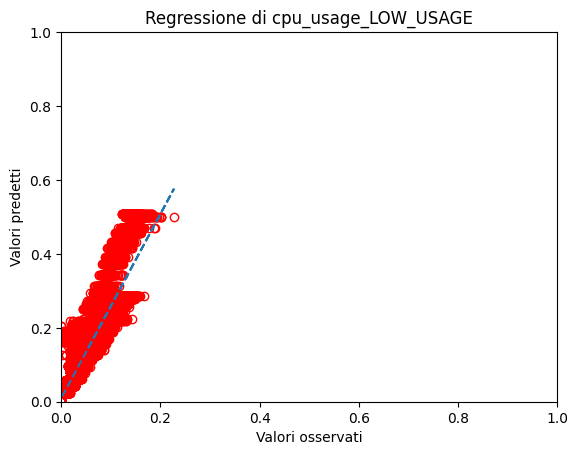

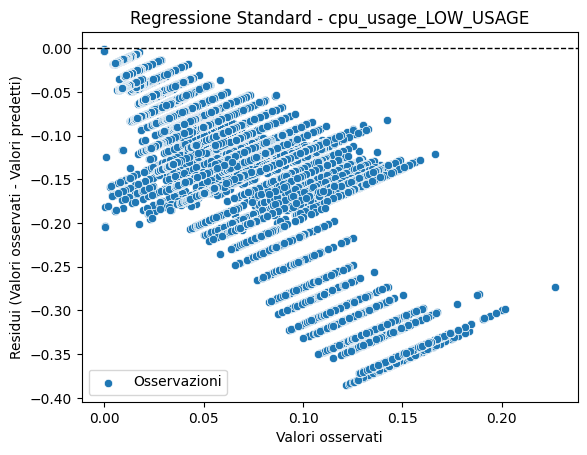

mape: 391826621723000.56
mse: 224.10853805689692
rmse: 14.970255109947088
R-squared score: -5.256054126982888
Standard deviation: 15.524580901711433
Quantile loss with library:  0.5608987587639238
------------------------------
Target: cpu_usage_LOW_USAGE quantiles
Prediction for alpha 0.05 are greater than true values in 82.75226757369614 % of cases and less or equal in 17.247732426303855 % of cases.
mape: 727672406.3851382
mse: 9.238741609426307e-05
rmse: 0.009611837290251175
R-squared score: 0.9477729813426822
Standard deviation: 0.045467241180162654
Quantile loss with library:  0.004742682332099161
mape: 20331354567354.13
mse: 0.0671390303812419
rmse: 0.2591120035452659
R-squared score: -36.95399352632274
Standard deviation: 0.2033391398985074
Quantile loss with library:  0.010104359088474665


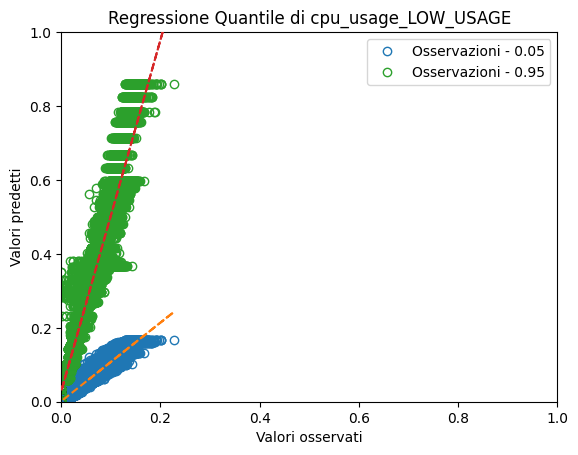

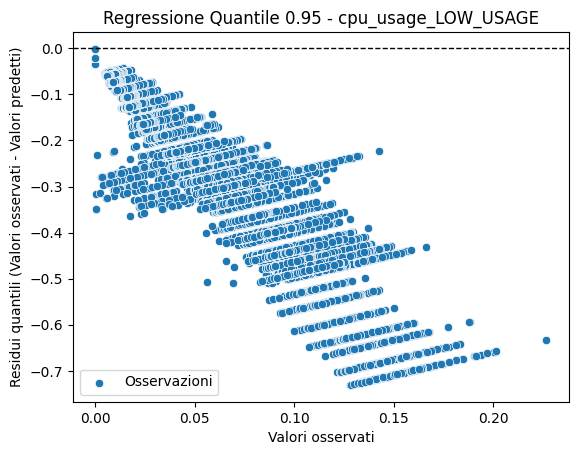

mape: 2893253411706831.0
mse: 1359.6132370272858
rmse: 36.87293366450906
R-squared score: -36.953993526322726
Standard deviation: 28.936176303257096
Quantile loss with library:  1.4379008200853878
------------------------------
Target: ram_usage_LOW_USAGE
mape: 1956458081657.6519
mse: 0.024391910049280582
rmse: 0.1561790960701226
R-squared score: -2.348093162442673
Standard deviation: 0.11464227182499687


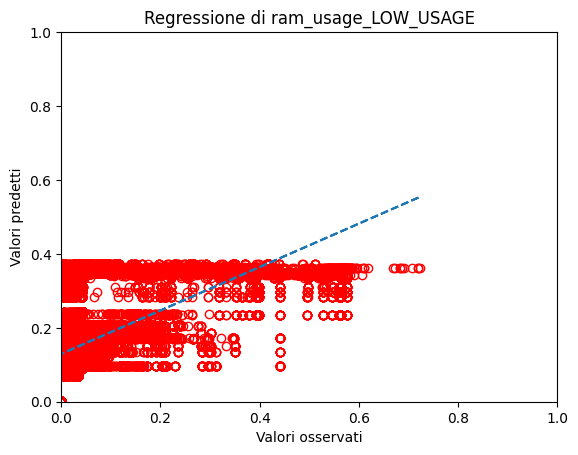

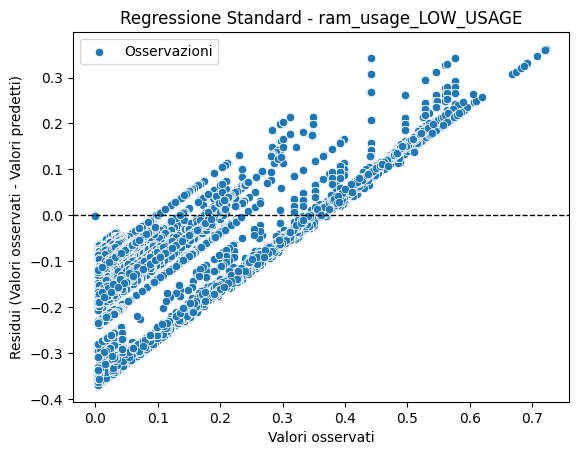

mape: 6.628774894144757e+20
mse: 2800085272930866.5
rmse: 52915831.9686166
R-squared score: -2.3480931624426744
Standard deviation: 38842529.79456524
Quantile loss with library:  3325624.6956256516
------------------------------
Target: ram_usage_LOW_USAGE quantiles
Prediction for alpha 0.05 are greater than true values in 47.23740686750891 % of cases and less or equal in 52.762593132491084 % of cases.
mape: 138081815.78966343
mse: 0.008644130463296616
rmse: 0.09297381600911418
R-squared score: -0.18651446487600576
Standard deviation: 0.003351125228559818
Quantile loss with library:  0.002321823657655761
Prediction for alpha 0.95 are greater than true values in 99.95242144476838 % of cases and less or equal in 0.04757855523161646 % of cases.
mape: 272924819332201.7
mse: 0.25497326337886644
rmse: 0.5049487730244192
R-squared score: -33.99825302732518
Standard deviation: 0.20276670808433492
Quantile loss with library:  0.023385237805602237


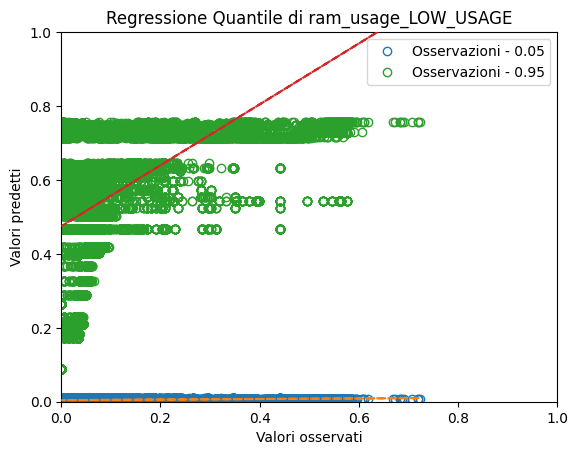

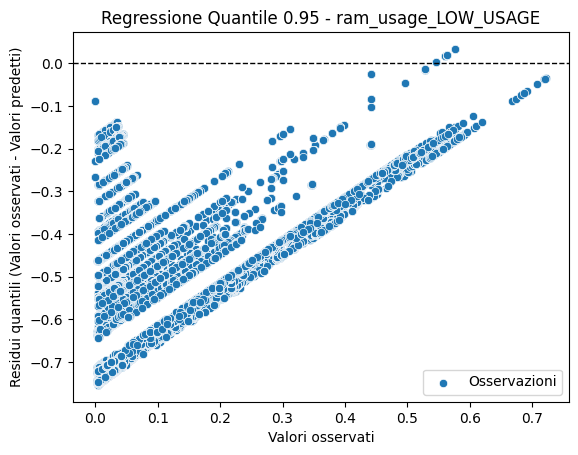

mape: 9.247104281716098e+22
mse: 2.926982259018883e+16
rmse: 171084255.82206222
R-squared score: -33.998253027325184
Standard deviation: 68700417.17364497
Quantile loss with library:  7923271.0740737505
------------------------------
Target: power_usage_LOW_USAGE
mape: 644671629669.5084
mse: 0.0010751079841036539
rmse: 0.03278883932230072
R-squared score: 0.8293261108863431
Standard deviation: 0.08551907623345831


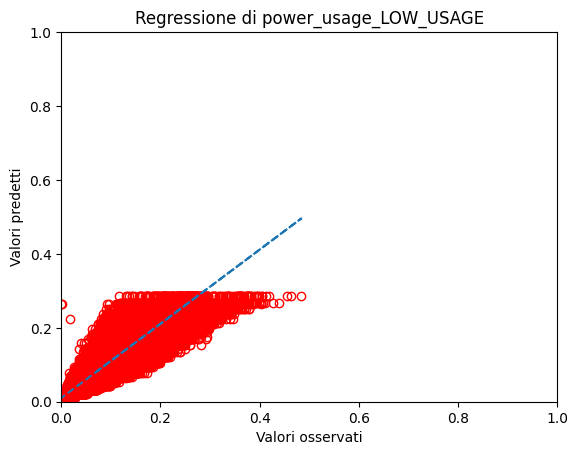

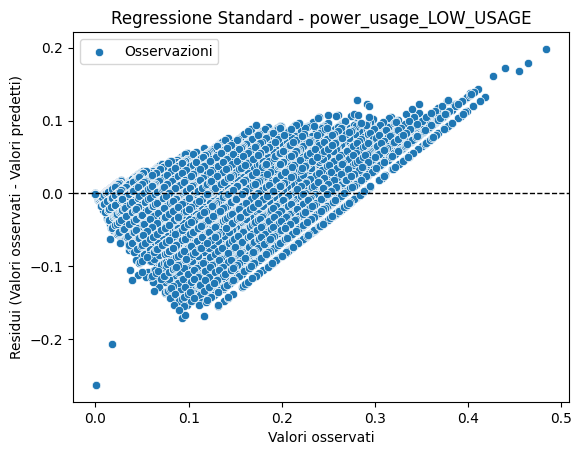

mape: 1.1005830902822605e+17
mse: 31334346.523927078
rmse: 5597.709042450052
R-squared score: 0.8293261108863432
Standard deviation: 14599.812504141268
Quantile loss with library:  974.0813340510151
------------------------------
Target: power_usage_LOW_USAGE quantiles
Prediction for alpha 0.05 are greater than true values in 30.105077745383866 % of cases and less or equal in 69.89492225461613 % of cases.
mape: 690974867.8411661
mse: 0.0026954510707495535
rmse: 0.05191773368271725
R-squared score: 0.5720958973772787
Standard deviation: 0.04701314856329011
Quantile loss with library:  0.0018085990391288529
Prediction for alpha 0.95 are greater than true values in 99.05956430191124 % of cases and less or equal in 0.9404356980887593 % of cases.
mape: 6734624254146.941
mse: 0.009535359694383974
rmse: 0.09764916637833615
R-squared score: -0.5137427562636518
Standard deviation: 0.1356784138349611
Quantile loss with library:  0.0035729423056074356


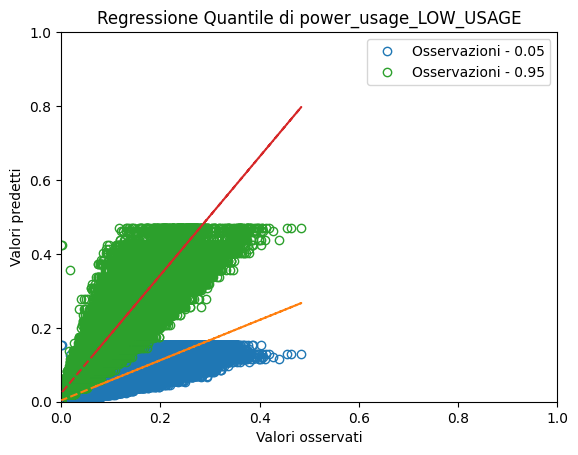

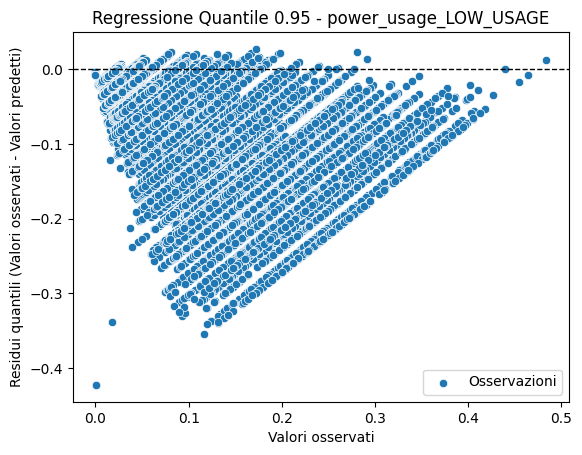

mape: 1.1497347226712387e+18
mse: 277910934.81946295
rmse: 16670.660899300394
R-squared score: -0.5137427562636512
Standard deviation: 23163.01216166228
Quantile loss with library:  609.9725353391285
------------------------------
Target: medium_latency_LOW_USAGE
mape: 1625239586854.8374
mse: 0.0014887177556672576
rmse: 0.03858390539677467
R-squared score: -0.5818991682347505
Standard deviation: 0.03672342694573913


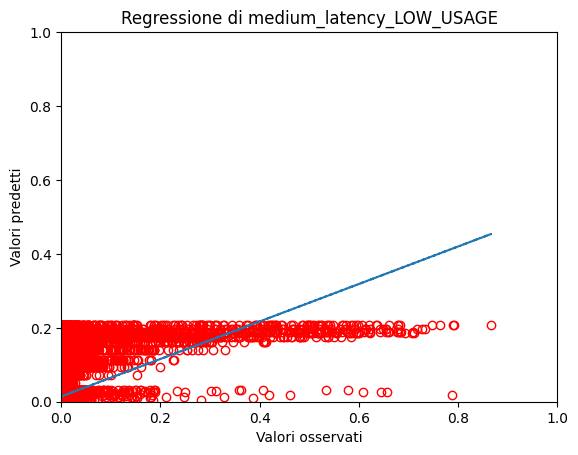

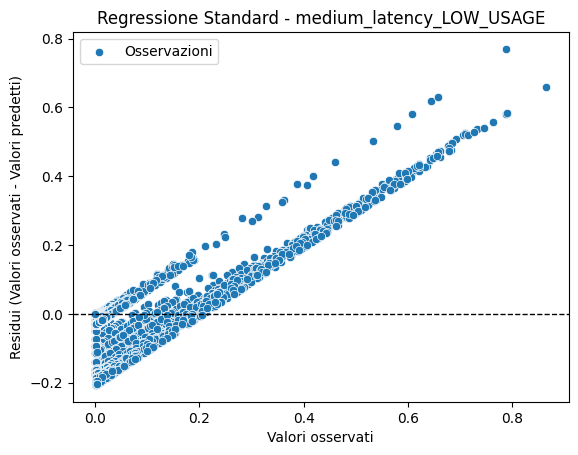

mape: 4.538214996603484e+22
mse: 1.1607741210033992e+18
rmse: 1077392278.1435735
R-squared score: -0.581899168234751
Standard deviation: 1025441468.701516
Quantile loss with library:  55804943.54895546
------------------------------
Target: medium_latency_LOW_USAGE quantiles
Prediction for alpha 0.05 are greater than true values in 36.87844185293165 % of cases and less or equal in 63.12155814706835 % of cases.
mape: 7673683.919993758
mse: 0.000945950206056196
rmse: 0.030756303517428682
R-squared score: -0.005158861345807786
Standard deviation: 0.0002999775918624629
Quantile loss with library:  0.0001868095128828035
Prediction for alpha 0.95 are greater than true values in 99.77121801101393 % of cases and less or equal in 0.22878198898607063 % of cases.
mape: 11078401450220.074
mse: 0.018564061949545255
rmse: 0.13624999797998258
R-squared score: -18.72601861249494
Standard deviation: 0.1266083897848592
Quantile loss with library:  0.0034583383012237005


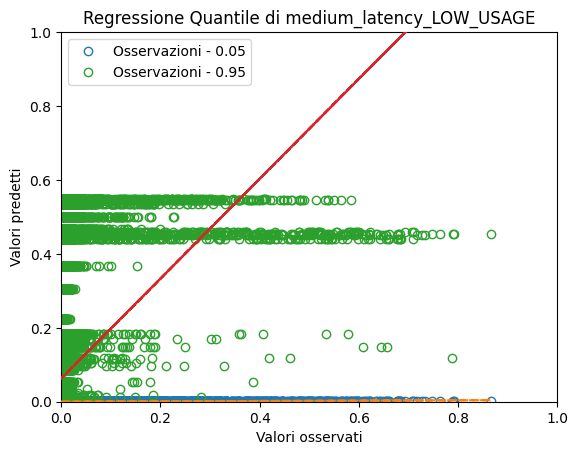

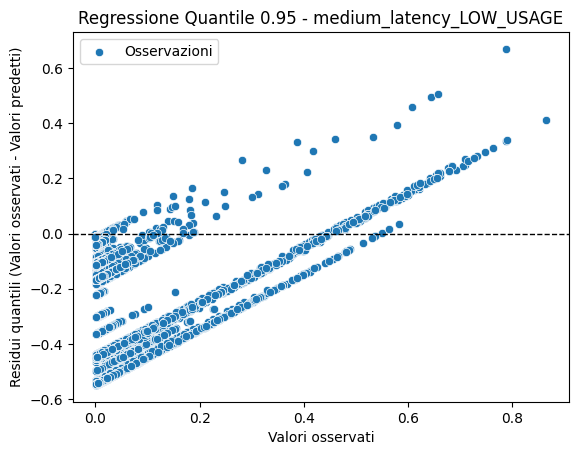

mape: 3.0934619121143036e+23
mse: 1.4474659558337642e+19
rmse: 3804557734.9197426
R-squared score: -18.72601861249494
Standard deviation: 3535331638.922211
Quantile loss with library:  96568425.16667695
------------------------------


In [172]:
pred_only_metrics = {}
pred_only_metrics_no_scale = {}
for target_name, y_pred in pred_only_predictions.items():
    print(f"Target: {target_name}")
    task_type = 'regression'

    if target_name.endswith('quantiles'):
        # Get the test dataset for the current iteration
        trunc_target = target_name[0:target_name.index(' ')]
        y_test = y_test_dict_pred[trunc_target]
        y_test_df = pd.DataFrame(y_test, columns=[trunc_target])
        y_pred_df = pd.DataFrame(y_pred, columns=quantiles_string)
        for quantile in QUANTILES:
            statistics = (y_pred_df[str(quantile)] > y_test_df[trunc_target]).value_counts(normalize=True)
            if statistics.size > 1:
                true_percentage, false_percentage = statistics[True], statistics[False]
                print(f"Prediction for alpha {quantile} are greater than true values in {true_percentage * 100} % of cases and less or equal in {false_percentage * 100} % of cases.")
            pred_only_metrics[target_name] = metrics(task_type, y_test_df, y_pred_df[str(quantile)], quantile) 
        plot_quantile_regression(y_test, y_pred_df, trunc_target)            
        # metrics on non-scaled predictions
        y_test_df_not_scaled = pd.DataFrame()
        for col in y_test_df:
            y_test_df_not_scaled[col] = [y[0] for y in y_scalers[trunc_target].inverse_transform(pd.DataFrame(y_test_df[col])).tolist()]
        y_pred_df_not_scaled = pd.DataFrame()
        for col in y_pred_df:
            y_pred_df_not_scaled[col] = [y[0] for y in y_scalers[trunc_target].inverse_transform(pd.DataFrame(y_pred_df[col])).tolist()]
        pred_only_metrics_no_scale[target_name] = metrics(task_type, y_test_df_not_scaled, y_pred_df_not_scaled[str(quantile)], quantile) 
    else:
        y_test = y_test_dict_pred[target_name]
        y_test_df = pd.DataFrame(y_test, columns=[target_name])
        y_pred_df = pd.DataFrame(y_pred, columns=[target_name])
        pred_only_metrics[target_name] = metrics(task_type, y_test_df, y_pred_df, 0)
        if task_type == 'regression':
            plot_regression(y_test, y_pred, target_name)   
        # metrics on non-scaled predictions
        y_test_df_not_scaled = pd.DataFrame()
        for col in y_test_df:
            y_test_df_not_scaled[col] = [y[0] for y in y_scalers[target_name].inverse_transform(pd.DataFrame(y_test_df[col])).tolist()]
        y_pred_df_not_scaled = pd.DataFrame()
        for col in y_pred_df:
            y_pred_df_not_scaled[col] = [y[0] for y in y_scalers[target_name].inverse_transform(pd.DataFrame(y_pred_df[col])).tolist()]
        pred_only_metrics_no_scale[target_name] = metrics(task_type, y_test_df_not_scaled, y_pred_df_not_scaled, quantile) 

    print("-" * 30)

pred_only_metrics = pd.DataFrame(pred_only_metrics).transpose()
pred_only_metrics_no_scale = pd.DataFrame(pred_only_metrics_no_scale).transpose()

In [173]:
pred_only_metrics.to_csv("output/metrics/groups/pred_only_metrics.csv")
pred_only_metrics

mape       mse      rmse  \
cpu_usage_LOW_USAGE                  2753428352645.358398  0.011067  0.105198   
cpu_usage_LOW_USAGE quantiles       20331354567354.128906  0.067139  0.259112   
ram_usage_LOW_USAGE                  1956458081657.651855  0.024392  0.156179   
ram_usage_LOW_USAGE quantiles        272924819332201.6875  0.254973  0.504949   
power_usage_LOW_USAGE                 644671629669.508423  0.001075  0.032789   
power_usage_LOW_USAGE quantiles      6734624254146.941406  0.009535  0.097649   
medium_latency_LOW_USAGE             1625239586854.837402  0.001489  0.038584   
medium_latency_LOW_USAGE quantiles  11078401450220.074219  0.018564   0.13625   

                                           r2                   quantile_loss  \
cpu_usage_LOW_USAGE                 -5.256054  Not calculated for this target   
cpu_usage_LOW_USAGE quantiles      -36.953994                        0.010104   
ram_usage_LOW_USAGE                 -2.348093  Not calculated for this target   
ram_usage_LOW_USAGE quantiles      -33.998253                        0.023385   
power_usage_LOW_USAGE                0.829326  Not calculated for this target   
power_usage_LOW_USAGE quantiles     -0.513743                        0.003573   
medium_latency_LOW_USAGE            -0.581899  Not calculated for this target   
medium_latency_LOW_USAGE quantiles -18.726019                        0.003458   

                                     std_dev  
cpu_usage_LOW_USAGE                 0.109094  
cpu_usage_LOW_USAGE quantiles       0.203339  
ram_usage_LOW_USAGE                 0.114642  
ram_usage_LOW_USAGE quantiles       0.202767  
power_usage_LOW_USAGE               0.085519  
power_usage_LOW_USAGE quantiles     0.135678  
medium_latency_LOW_USAGE            0.036723  
medium_latency_LOW_USAGE quantiles  0.126608

In [174]:
pred_only_metrics_no_scale.to_csv("output/metrics/groups/pred_only_metrics_no_scale.csv")
pred_only_metrics_no_scale

mape           mse          rmse  \
cpu_usage_LOW_USAGE                 3.918266e+14  2.241085e+02  1.497026e+01   
cpu_usage_LOW_USAGE quantiles       2.893253e+15  1.359613e+03  3.687293e+01   
ram_usage_LOW_USAGE                 6.628775e+20  2.800085e+15  5.291583e+07   
ram_usage_LOW_USAGE quantiles       9.247104e+22  2.926982e+16  1.710843e+08   
power_usage_LOW_USAGE               1.100583e+17  3.133435e+07  5.597709e+03   
power_usage_LOW_USAGE quantiles     1.149735e+18  2.779109e+08  1.667066e+04   
medium_latency_LOW_USAGE            4.538215e+22  1.160774e+18  1.077392e+09   
medium_latency_LOW_USAGE quantiles  3.093462e+23  1.447466e+19  3.804558e+09   

                                           r2  quantile_loss       std_dev  
cpu_usage_LOW_USAGE                 -5.256054   5.608988e-01  1.552458e+01  
cpu_usage_LOW_USAGE quantiles      -36.953994   1.437901e+00  2.893618e+01  
ram_usage_LOW_USAGE                 -2.348093   3.325625e+06  3.884253e+07  
ram_usage_LOW_USAGE quantiles      -33.998253   7.923271e+06  6.870042e+07  
power_usage_LOW_USAGE                0.829326   9.740813e+02  1.459981e+04  
power_usage_LOW_USAGE quantiles     -0.513743   6.099725e+02  2.316301e+04  
medium_latency_LOW_USAGE            -0.581899   5.580494e+07  1.025441e+09  
medium_latency_LOW_USAGE quantiles -18.726019   9.656843e+07  3.535332e+09